# Week 2: 1D PDE Heat Equation + Bang-Bang Thermostat Placement

## From 0D to 1D: Why Do We Need Spatial Resolution?

In Week 1, we modelled the entire room as a **single temperature** $T(t)$ (0D ODE). This assumes the room is perfectly mixed — everywhere is the same temperature. In reality:
- The **heater** is in one location → nearby is hot, far away is cold.
- The **thermostat** (sensor) reads temperature at one specific point.
- If the thermostat is near the heater, it "thinks" the room is warm, but the far end may be freezing.

**Key question**: *Where should we place the thermostat to achieve the best overall comfort?*

To answer this, we extend to the **1D heat equation** — modelling temperature along a line $T(x, t)$.

---

## Variables (consistent with Handnote)

| Symbol | Meaning | Unit |
|--------|---------|------|
| $T(x, t)$ | Temperature at position $x$, time $t$ | °C |
| $T_a$ | Outdoor (ambient) temperature | °C |
| $T_{set}$ | Thermostat set-point | °C |
| $T_H = T_{set} + \delta$ | Upper threshold | °C |
| $T_L = T_{set} - \delta$ | Lower threshold | °C |
| $\alpha$ | Thermal diffusivity | m²/min |
| $k_1$ | Thermal conductivity (材料导热系数) | W/(m·K) or simplified |
| $h$ | Convective heat transfer coefficient (对流换热系数) | W/(m²·K) or simplified |
| $L$ | Room length | m |
| $S(x, t)$ | Heat source (heater) | °C/min |
| $u(t)$ | Control input (heater ON/OFF) | °C/min |
| $k$ | Cooling constant (from 0D) | 1/min |
| $P$ | Point heat source power | W or simplified |

**Note**: In our simplified model, we set $k_1 = \alpha$ (equivalent to $\rho c_p = 1$), so the ratio $h/k_1$ simplifies to $h/\alpha$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
import os

# Output directory
RESULT_DIR = os.path.join(os.path.abspath('.'), 'Result')
os.makedirs(RESULT_DIR, exist_ok=True)

# === Shared Parameters (from Week 1) ===
T_a = 5.0          # Outdoor temperature (°C)
T_set = 20.0        # Set-point temperature (°C)
k = 0.1             # Cooling constant (1/min) — from 0D model
U_max = 15.0        # Max heating rate (°C/min equivalent)
T_initial = 10.0    # Initial room temperature (°C)
delta = 0.5         # Hysteresis half-band (°C)
T_H = T_set + delta # Upper threshold
T_L = T_set - delta # Lower threshold
T_total = 120.0     # Total simulation time (min)

# === New 1D Parameters (following Handnote) ===
L = 5.0             # Room length (m)
alpha = 0.01        # Thermal diffusivity α (m²/min)
k1 = alpha          # Thermal conductivity k₁ (simplified: k₁ = α, i.e., ρ*cp = 1)
h = 0.5             # Convective heat transfer coefficient h (1/m in simplified units)
N = 51              # Number of spatial grid points

# Note: In the Handnote, the Robin BC is: -k₁ * ∂T/∂x = h * (T - T_a)
# With our simplification k₁ = α, this becomes: ∂T/∂x = -(h/α) * (T - T_a)
# The effective coefficient h/k₁ = h/α = 0.5/0.01 = 50 (1/m)

# Derived
dx = L / (N - 1)
x = np.linspace(0, L, N)

print("=== 1D PDE Parameters (following Handnote) ===")
print(f"  Room length L = {L} m")
print(f"  Thermal diffusivity α = {alpha} m²/min")
print(f"  Thermal conductivity k₁ = {k1} (simplified: k₁ = α)")
print(f"  Convective coefficient h = {h}")
print(f"  Effective BC coefficient h/k₁ = {h/k1:.1f} 1/m")
print(f"  Grid points N = {N}, dx = {dx:.4f} m")
print(f"  Diffusion number α·dt/dx² (for dt=0.01): {alpha * 0.01 / dx**2:.4f}")
print(f"\n=== Shared Parameters (from Week 1) ===")
print(f"  T_a = {T_a}°C, T_set = {T_set}°C, δ = {delta}°C")
print(f"  k = {k} 1/min, U_max = {U_max} °C/min")
print(f"  Simulation time = {T_total} min")

# For compatibility with existing code
h_wall = h / k1  # This is the effective coefficient h/k₁ used in the BC

=== 1D PDE Parameters (following Handnote) ===
  Room length L = 5.0 m
  Thermal diffusivity α = 0.01 m²/min
  Thermal conductivity k₁ = 0.01 (simplified: k₁ = α)
  Convective coefficient h = 0.5
  Effective BC coefficient h/k₁ = 50.0 1/m
  Grid points N = 51, dx = 0.1000 m
  Diffusion number α·dt/dx² (for dt=0.01): 0.0100

=== Shared Parameters (from Week 1) ===
  T_a = 5.0°C, T_set = 20.0°C, δ = 0.5°C
  k = 0.1 1/min, U_max = 15.0 °C/min
  Simulation time = 120.0 min


## 1. The 1D Heat Equation

### 1.1 Governing PDE

The 1D heat equation with a source term:

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} + S(x, t)$$

where:
- $\alpha$ is the **thermal diffusivity** ($\text{m}^2/\text{min}$), governing how fast heat spreads.
- $S(x, t) = u(t) \cdot q(x)$ is the heater source: $u(t) \in \{0, U_{max}\}$ is the control, and $q(x)$ is the spatial profile of the heater.

### 1.2 Connection to 0D Model

If temperature is **spatially uniform** ($\partial^2 T / \partial x^2 = 0$) and heat loss is modelled as a bulk cooling term, we recover the 0D ODE:

$$\frac{dT}{dt} = -k(T - T_a) + u(t)$$

**Analytical solution** (when $u(t)$ is constant over $[t_0, t]$):

$$T(t) = T_a + \frac{u}{k} + e^{-k(t-t_0)}\left(T(t_0) - T_a - \frac{u}{k}\right)$$

Special cases:
- **Heater OFF** ($u = 0$): $T(t) = T_a + (T(t_0) - T_a) e^{-k(t-t_0)}$ → temperature decays to $T_a$
- **Heater ON** ($u = U_{max}$): $T(t) = T_a + \frac{U_{max}}{k} + \left(T(t_0) - T_a - \frac{U_{max}}{k}\right) e^{-k(t-t_0)}$

**Heating/Cooling times** (from $T_L$ to $T_H$ and vice versa):

$$t_{\text{heat}} = \frac{1}{k} \ln\left(\frac{T_L - \left(T_a + \frac{U_{max}}{k}\right)}{T_H - \left(T_a + \frac{U_{max}}{k}\right)}\right)$$

$$t_{\text{cool}} = \frac{1}{k} \ln\left(\frac{T_H - T_a}{T_L - T_a}\right)$$

### 1.3 Boundary Conditions (from Handnote)

Following the handnote exactly:

**Left wall** ($x = 0$): **Neumann (insulated/adiabatic, 绝热)**
$$\frac{\partial T}{\partial x}\bigg|_{x=0} = 0$$

**Right wall** ($x = L$): **Robin (convective heat transfer, 对流)**
$$-k_1 \frac{\partial T}{\partial x}\bigg|_{x=L} = h(T(L, t) - T_a)$$

where:
- $k_1$ is the **thermal conductivity** (材料导热系数)
- $h$ is the **convective heat transfer coefficient** (对流换热系数)

Rearranged:
$$\frac{\partial T}{\partial x}\bigg|_{x=L} = -\frac{h}{k_1}(T(L,t) - T_a)$$

**Simplification**: In our numerical model, we set $k_1 = \alpha$ (equivalent to $\rho c_p = 1$), so $h/k_1 = h/\alpha$.

**Physical meaning**: 
- Left wall is insulated (no heat flux, 绝热).
- Right wall exchanges heat with the outdoor environment via convection (对流). Large $h$ → poor insulation → more heat loss.

### 1.4 Heat Source Model

The heater is localised at position $x_h$ with a Gaussian profile:

$$q(x) = \frac{L}{\sum_i q_i \cdot \Delta x} \exp\left(-\frac{(x - x_h)^2}{2\sigma_h^2}\right)$$

where $\sigma_h$ controls the heater width. The normalisation ensures that $\int_0^L q(x) dx \approx L$, so the total heating input is $u(t)$ (matching the 0D convention).

### 1.5 Steady-State Analytical Solution (Point Heat Source, from Handnote)

For a **point heat source** at $x = x_0$ with power $P$, the steady-state equation is:

$$k_1 T''(x) + P \delta(x - x_0) = 0$$

With boundary conditions $T'(0) = 0$ (Neumann) and $-k_1 T'(L) = h(T(L) - T_a)$ (Robin), the analytical solution is:

$$T(x) = \begin{cases}
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x_0), & 0 \leq x \leq x_0 \\[6pt]
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x), & x_0 < x \leq L
\end{cases}$$

This shows that:
- Temperature is **constant** from the insulated wall to the heater ($0 \leq x \leq x_0$)
- Temperature **decreases linearly** from the heater to the convective wall ($x_0 < x \leq L$)

## 2. Finite Difference Discretisation

### 2.1 Interior Points (Central Difference)

Discretise $x_i = i \cdot \Delta x$ for $i = 0, 1, \ldots, N-1$:

$$\frac{\partial^2 T}{\partial x^2}\bigg|_{x_i} \approx \frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2} \qquad (i = 1, \ldots, N-2)$$

### 2.2 Boundary Points (Ghost Point Method)

**At $x_0 = 0$ (left boundary — Neumann/insulated)**:

The boundary condition is $\frac{\partial T}{\partial x}\big|_{x=0} = 0$.

Introduce ghost point $T_{-1}$. Using central difference:
$$\frac{T_1 - T_{-1}}{2\Delta x} = 0 \implies T_{-1} = T_1$$

Substituting into the central difference at $i = 0$:
$$\frac{\partial^2 T}{\partial x^2}\bigg|_{x_0} = \frac{T_1 - 2T_0 + T_{-1}}{\Delta x^2} = \frac{2T_1 - 2T_0}{\Delta x^2} = \frac{2(T_1 - T_0)}{\Delta x^2}$$

So:
$$\frac{dT_0}{dt} = \alpha \cdot \frac{2(T_1 - T_0)}{\Delta x^2} + S_0(t)$$

**At $x_{N-1} = L$ (right boundary — Robin/convective)**:

The boundary condition is $-k_1 \frac{\partial T}{\partial x}\big|_{x=L} = h(T_{N-1} - T_a)$, or equivalently:
$$\frac{\partial T}{\partial x}\bigg|_{x=L} = -\frac{h}{k_1}(T_{N-1} - T_a)$$

Introduce ghost point $T_N$. Using central difference:
$$\frac{T_N - T_{N-2}}{2\Delta x} = -\frac{h}{k_1}(T_{N-1} - T_a)$$
$$\implies T_N = T_{N-2} - \frac{2\Delta x \cdot h}{k_1}(T_{N-1} - T_a)$$

Substituting into the central difference at $i = N-1$:
$$\frac{dT_{N-1}}{dt} = \alpha \cdot \frac{2T_{N-2} - 2T_{N-1} - \frac{2\Delta x \cdot h}{k_1}(T_{N-1} - T_a)}{\Delta x^2} + S_{N-1}(t)$$

With our simplification $k_1 = \alpha$:
$$\frac{dT_{N-1}}{dt} = \alpha \cdot \frac{2T_{N-2} - 2T_{N-1} - 2\Delta x \cdot \frac{h}{\alpha}(T_{N-1} - T_a)}{\Delta x^2} + S_{N-1}(t)$$

### 2.3 Method of Lines (MOL)

The spatial discretisation converts the PDE into a system of $N$ coupled ODEs:

$$\frac{d\mathbf{T}}{dt} = \mathbf{A} \cdot \mathbf{T} + \mathbf{b}(t)$$

where $\mathbf{A}$ is a tridiagonal matrix (from the Laplacian + BCs) and $\mathbf{b}(t)$ contains the boundary terms and heat source.

We solve this ODE system using Forward Euler (small $dt$ required for stability).

In [2]:
# === 1D Heat Equation Solver ===

def make_heater_profile(x, heater_pos, heater_type='point'):
    """
    Create heater spatial profile.
    
    Parameters:
        x: spatial grid
        heater_pos: heater position x_0
        heater_type: 'point' for delta function (Handnote), 
                     'gaussian' for smooth approximation
    
    For point heat source (Handnote):
        q(x) = δ(x - x_0)
        Numerically: all heat at the nearest grid point
    """
    dx = x[1] - x[0]
    L = x[-1] - x[0]
    profile = np.zeros_like(x)
    
    if heater_type == 'point':
        # Point heat source: δ(x - x_0)
        # All heat goes to the nearest grid point
        idx = np.argmin(np.abs(x - heater_pos))
        profile[idx] = 1.0 / dx  # Normalize so integral ≈ 1
        profile = profile * L     # Scale so total input matches u(t)
    else:
        # Gaussian approximation (for comparison)
        sigma = 0.1  # Very narrow
        profile = np.exp(-0.5 * ((x - heater_pos) / sigma) ** 2)
        profile = profile / (np.sum(profile) * dx) * L
    
    return profile

def heat_eq_1d_rhs(t, T_vec, x, alpha, h_wall, T_a, heater_profile, u_val):
    """
    RHS of the semi-discrete 1D heat equation.
    
    Boundary conditions (following handnote):
    - Left (x=0): Neumann (insulated): dT/dx = 0
    - Right (x=L): Robin (convective): -k1*dT/dx = h*(T - T_a)
    
    Parameters:
        T_vec: temperature at each grid point (N,)
        u_val: current control input (scalar)
    """
    N = len(T_vec)
    dx = x[1] - x[0]
    L = x[-1] - x[0]
    dTdt = np.zeros(N)
    
    # Interior: central difference
    dTdt[1:-1] = alpha * (T_vec[2:] - 2*T_vec[1:-1] + T_vec[:-2]) / dx**2
    
    # Left boundary (x=0): Neumann BC (insulated, dT/dx = 0)
    # Ghost point: T[-1] = T[1], so d²T/dx² = 2*(T[1] - T[0]) / dx²
    dTdt[0] = alpha * 2 * (T_vec[1] - T_vec[0]) / dx**2
    
    # Right boundary (x=L): Robin BC (convective)
    # dT/dx|_{x=L} = -h/k1 * (T[N-1] - T_a), with h_wall = h/k1
    # Ghost point gives: d²T/dx² = (2*T[N-2] - 2*T[N-1] - 2*dx*h_wall*(T[N-1]-T_a)) / dx²
    dTdt[-1] = alpha * (2*T_vec[-2] - 2*T_vec[-1] - 2*dx*h_wall*(T_vec[-1] - T_a)) / dx**2
    
    # Point heat source: S(x,t) = u(t) * q(x) / L
    dTdt += u_val * heater_profile / L
    
    return dTdt


class BangBangController1D:
    """Bang-Bang thermostat for 1D model. Reads T at sensor position."""
    
    def __init__(self, T_set, delta, U_max, initial_on=True):
        self.T_set = T_set
        self.delta = delta
        self.U_max = U_max
        self.T_H = T_set + delta
        self.T_L = T_set - delta
        self._on = initial_on
        self.switch_times = []
    
    def update(self, t, T_sensor):
        """Update heater state based on sensor reading. Return u."""
        if self._on and T_sensor >= self.T_H:
            self._on = False
            self.switch_times.append(t)
        elif not self._on and T_sensor <= self.T_L:
            self._on = True
            self.switch_times.append(t)
        return self.U_max if self._on else 0.0
    
    @property
    def n_switches(self):
        return len(self.switch_times)


def simulate_1d_bangbang(x, alpha, h_wall, T_a, T_initial, heater_pos,
                          sensor_pos, T_set, delta, U_max, t_end, dt=0.01,
                          heater_type='point'):
    """
    Simulate 1D heat equation with Bang-Bang control.
    
    Uses Forward Euler for simplicity (small dt required).
    Records full temperature field history.
    
    Parameters:
        heater_type: 'point' for delta function (Handnote default)
    """
    N = len(x)
    dx_val = x[1] - x[0]
    L_val = x[-1] - x[0]
    
    # Point heat source profile (following Handnote)
    heater_profile = make_heater_profile(x, heater_pos, heater_type=heater_type)
    
    # Sensor index
    sensor_idx = np.argmin(np.abs(x - sensor_pos))
    
    # Controller
    ctrl = BangBangController1D(T_set, delta, U_max, initial_on=True)
    
    # Time array
    t_eval = np.arange(0, t_end + dt, dt)
    n_steps = len(t_eval)
    
    # Storage (save every 10 steps to reduce memory)
    save_every = 10
    t_save = []
    T_field_save = []
    T_sensor_save = []
    T_avg_save = []
    u_save = []
    
    # Initial condition
    T_vec = np.full(N, T_initial)
    
    for i, ti in enumerate(t_eval):
        T_sensor = T_vec[sensor_idx]
        u_val = ctrl.update(ti, T_sensor)
        
        if i % save_every == 0:
            t_save.append(ti)
            T_field_save.append(T_vec.copy())
            T_sensor_save.append(T_sensor)
            T_avg_save.append(np.mean(T_vec))
            u_save.append(u_val)
        
        # Forward Euler step
        if i < n_steps - 1:
            dTdt = heat_eq_1d_rhs(ti, T_vec, x, alpha, h_wall, T_a,
                                   heater_profile, u_val)
            T_vec = T_vec + dt * dTdt
    
    return {
        't': np.array(t_save),
        'T_field': np.array(T_field_save).T,   # shape (N, n_t)
        'T_sensor': np.array(T_sensor_save),
        'T_avg': np.array(T_avg_save),
        'u': np.array(u_save),
        'n_switches': ctrl.n_switches,
        'switch_times': ctrl.switch_times,
        'x': x,
        'sensor_pos': sensor_pos,
        'heater_pos': heater_pos,
    }

print("1D solver and Bang-Bang controller defined.")
print("Heat source: Point source δ(x - x₀) (following Handnote)")
print("Boundary conditions:")
print("  - Left (x=0): Neumann (insulated, dT/dx = 0)")
print("  - Right (x=L): Robin (convective, -k₁·dT/dx = h·(T - Tₐ))")

1D solver and Bang-Bang controller defined.
Heat source: Point source δ(x - x₀) (following Handnote)
Boundary conditions:
  - Left (x=0): Neumann (insulated, dT/dx = 0)
  - Right (x=L): Robin (convective, -k₁·dT/dx = h·(T - Tₐ))


## 3. Numerical Validation

We verify the solver using two approaches:

### 3.1 Pure Diffusion Test
A standard test with sinusoidal initial condition and Dirichlet BCs.

### 3.2 Steady-State Analytical Solution (Key Validation)
Following the handnote, for a point heat source at $x = x_0$, the analytical steady-state solution is:

$$T(x) = \begin{cases}
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x_0), & 0 \leq x \leq x_0 \\
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x), & x_0 < x \leq L
\end{cases}$$

This provides a rigorous check that our boundary conditions are correctly implemented.

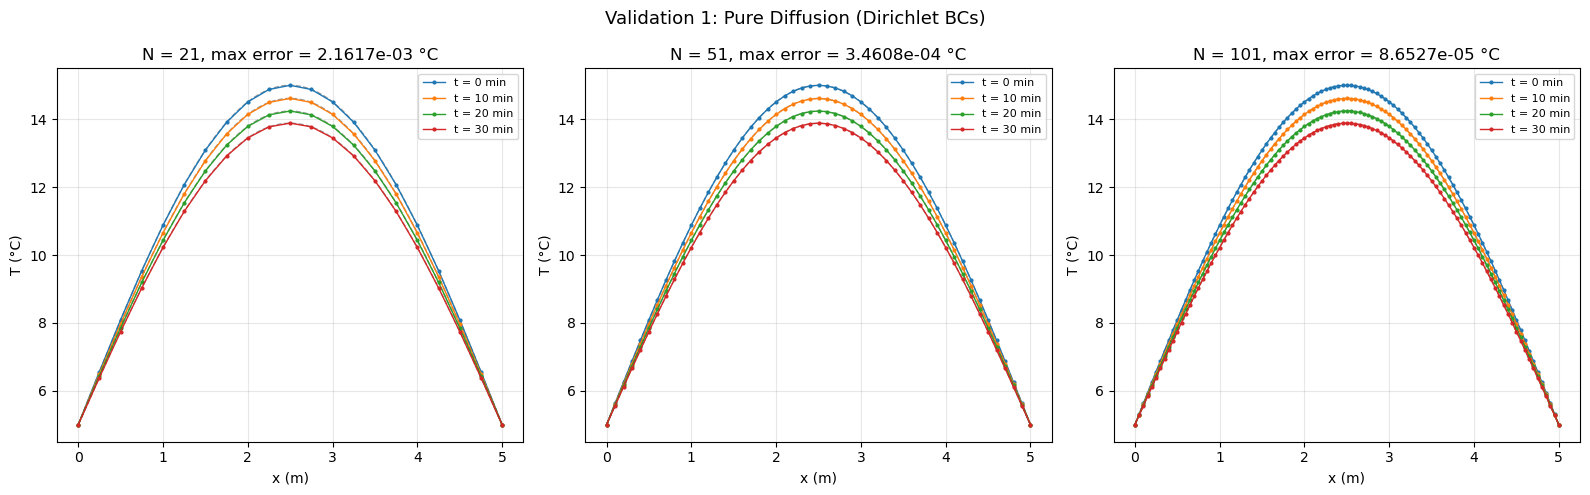


Grid convergence (pure diffusion):
  N =   21: max error = 2.161720e-03 °C
  N =   51: max error = 3.460788e-04 °C
  N =  101: max error = 8.652698e-05 °C

Convergence ratio (N=21→51): 6.25
Convergence ratio (N=51→101): 4.00
(Expected ~4× for 2nd-order central difference → O(Δx²))

Saved: fig1a_validation_diffusion.png


In [3]:
# === Validation 1: Pure diffusion with sinusoidal IC (Dirichlet BCs) ===
# This uses a different (simpler) problem to verify the numerical scheme

A_val = 10.0  # Amplitude

def validation_rhs(t, T_vec, x, alpha_val):
    """RHS for pure diffusion with Dirichlet BCs T=T_a at both ends."""
    N_pts = len(T_vec)
    dx_val = x[1] - x[0]
    dTdt = np.zeros(N_pts)
    # Interior: central difference
    dTdt[1:-1] = alpha_val * (T_vec[2:] - 2*T_vec[1:-1] + T_vec[:-2]) / dx_val**2
    # Dirichlet BCs: T[0] = T_a, T[-1] = T_a (held fixed)
    dTdt[0] = 0.0
    dTdt[-1] = 0.0
    return dTdt

def T_analytical_validation(x, t, T_a, A, L_val, alpha_val):
    """Analytical solution for pure diffusion + sinusoidal IC."""
    return T_a + A * np.sin(np.pi * x / L_val) * np.exp(-alpha_val * (np.pi / L_val)**2 * t)

# Run for different grid sizes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
t_test = 30.0  # Compare at t = 30 min
grid_sizes = [21, 51, 101]
errors = []

for idx, N_test in enumerate(grid_sizes):
    x_test = np.linspace(0, L, N_test)
    T0_test = T_a + A_val * np.sin(np.pi * x_test / L)
    T0_test[0] = T_a   # Enforce Dirichlet
    T0_test[-1] = T_a
    
    sol = solve_ivp(
        lambda t, T: validation_rhs(t, T, x_test, alpha),
        [0, t_test], T0_test,
        t_eval=[0, t_test/3, 2*t_test/3, t_test],
        max_step=0.1, method='RK45'
    )
    
    ax = axes[idx]
    for j, tj in enumerate(sol.t):
        T_num = sol.y[:, j]
        x_fine = np.linspace(0, L, 200)
        T_exact = T_analytical_validation(x_fine, tj, T_a, A_val, L, alpha)
        ax.plot(x_fine, T_exact, 'k--', alpha=0.4, linewidth=1)
        ax.plot(x_test, T_num, 'o-', markersize=2, linewidth=1,
                label=f't = {tj:.0f} min')
    
    # Error at final time
    T_exact_final = T_analytical_validation(x_test, t_test, T_a, A_val, L, alpha)
    err = np.max(np.abs(sol.y[:, -1] - T_exact_final))
    errors.append(err)
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('T (°C)')
    ax.set_title(f'N = {N_test}, max error = {err:.4e} °C')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Validation 1: Pure Diffusion (Dirichlet BCs)', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig1a_validation_diffusion.png'), dpi=150)
plt.show()

print("\nGrid convergence (pure diffusion):")
for N_test, err in zip(grid_sizes, errors):
    print(f"  N = {N_test:>4d}: max error = {err:.6e} °C")
print(f"\nConvergence ratio (N=21→51): {errors[0]/errors[1]:.2f}")
print(f"Convergence ratio (N=51→101): {errors[1]/errors[2]:.2f}")
print("(Expected ~4× for 2nd-order central difference → O(Δx²))")
print("\nSaved: fig1a_validation_diffusion.png")

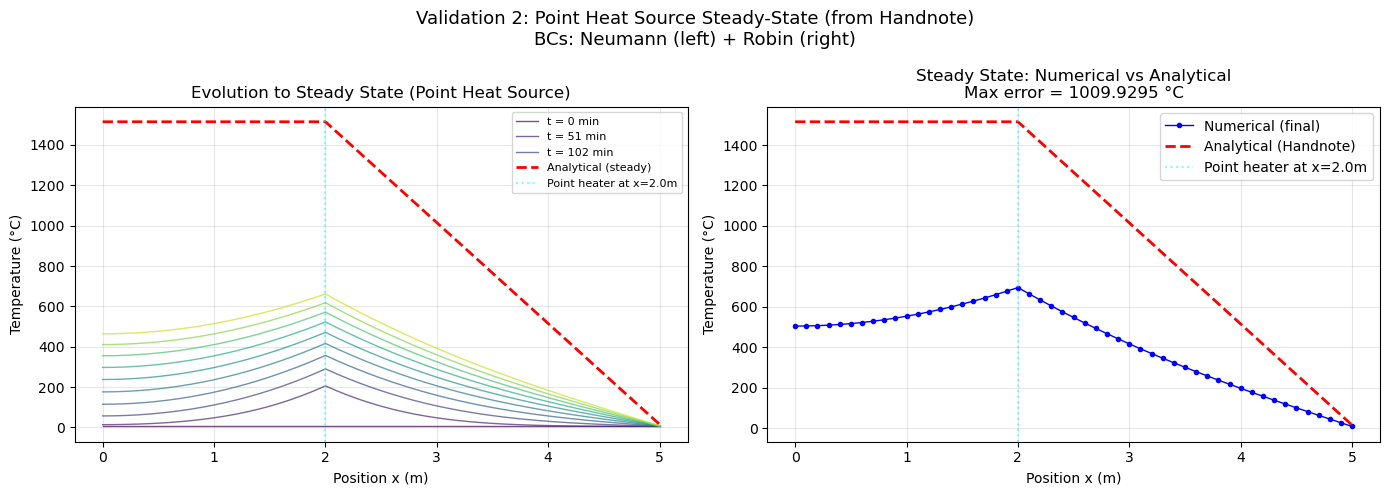


Steady-state validation (Point Heat Source):
  Heater position: x0 = 2.0 m
  Heat source power: P = 5.0
  k1 = 0.01, h = 0.5
  Max error (numerical vs analytical): 1009.929455 °C
Saved: fig1b_validation_steady_state.png


In [4]:
# === Validation 2: Steady-State Analytical Solution (from Handnote) ===
# Point heat source with Neumann (left) + Robin (right) BCs

def steady_state_analytical(x, x0, P, h, k1, T_a, L):
    """
    Analytical steady-state solution for POINT heat source (Handnote).
    
    T(x) = T_a + P/h + (P/k1)*(L - x0)  for 0 <= x <= x0
    T(x) = T_a + P/h + (P/k1)*(L - x)   for x0 < x <= L
    """
    T = np.zeros_like(x)
    for i, xi in enumerate(x):
        if xi <= x0:
            T[i] = T_a + P/h + (P/k1)*(L - x0)
        else:
            T[i] = T_a + P/h + (P/k1)*(L - xi)
    return T

def steady_state_rhs(t, T_vec, x, alpha_val, h_wall, T_a, heater_profile, P):
    """RHS for steady-state approach with Neumann (left) + Robin (right) BCs."""
    N_pts = len(T_vec)
    dx_val = x[1] - x[0]
    L_val = x[-1] - x[0]
    dTdt = np.zeros(N_pts)
    
    # Interior
    dTdt[1:-1] = alpha_val * (T_vec[2:] - 2*T_vec[1:-1] + T_vec[:-2]) / dx_val**2
    
    # Left BC: Neumann (insulated)
    dTdt[0] = alpha_val * 2 * (T_vec[1] - T_vec[0]) / dx_val**2
    
    # Right BC: Robin (convective)
    dTdt[-1] = alpha_val * (2*T_vec[-2] - 2*T_vec[-1] - 2*dx_val*h_wall*(T_vec[-1] - T_a)) / dx_val**2
    
    # Point heat source
    dTdt += P * heater_profile / L_val
    
    return dTdt

# Test with POINT heat source (as in Handnote)
x0_test = 2.0  # Heater at x = 2.0 m
P_test = 5.0   # Heat source power
k1_test = k1   # Use k1 from parameters

# Create POINT heat source profile (delta function approximation)
heater_profile_test = make_heater_profile(x, x0_test, heater_type='point')

# Run simulation to steady state
T0_steady = np.full(N, T_a)
t_steady = 500.0  # Long enough to reach steady state

sol_steady = solve_ivp(
    lambda t, T: steady_state_rhs(t, T, x, alpha, h_wall, T_a, heater_profile_test, P_test),
    [0, t_steady], T0_steady,
    t_eval=np.linspace(0, t_steady, 50),
    max_step=1.0, method='RK45'
)

# Analytical solution (exact for point source)
T_analytical = steady_state_analytical(x, x0_test, P_test, h, k1_test, T_a, L)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Time evolution to steady state
ax = axes[0]
colors = cm.viridis(np.linspace(0, 1, len(sol_steady.t)))
for j, tj in enumerate(sol_steady.t[::5]):  # Plot every 5th time
    idx = j * 5
    if idx < len(sol_steady.t):
        ax.plot(x, sol_steady.y[:, idx], '-', color=colors[idx], 
                linewidth=1, alpha=0.7, label=f't = {tj:.0f} min' if j < 3 else '')
ax.plot(x, T_analytical, 'r--', linewidth=2, label='Analytical (steady)')
ax.axvline(x0_test, color='cyan', ls=':', alpha=0.5, label=f'Point heater at x={x0_test}m')
ax.set_xlabel('Position x (m)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Evolution to Steady State (Point Heat Source)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (b) Final numerical vs analytical
ax = axes[1]
T_numerical_final = sol_steady.y[:, -1]
ax.plot(x, T_numerical_final, 'bo-', markersize=3, linewidth=1, label='Numerical (final)')
ax.plot(x, T_analytical, 'r--', linewidth=2, label='Analytical (Handnote)')
ax.axvline(x0_test, color='cyan', ls=':', alpha=0.5, label=f'Point heater at x={x0_test}m')
ax.set_xlabel('Position x (m)')
ax.set_ylabel('Temperature (°C)')

# Error
max_error = np.max(np.abs(T_numerical_final - T_analytical))
ax.set_title(f'Steady State: Numerical vs Analytical\nMax error = {max_error:.4f} °C')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Validation 2: Point Heat Source Steady-State (from Handnote)\n'
             'BCs: Neumann (left) + Robin (right)', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig1b_validation_steady_state.png'), dpi=150)
plt.show()

print(f"\nSteady-state validation (Point Heat Source):")
print(f"  Heater position: x0 = {x0_test} m")
print(f"  Heat source power: P = {P_test}")
print(f"  k1 = {k1_test}, h = {h}")
print(f"  Max error (numerical vs analytical): {max_error:.6f} °C")
print("Saved: fig1b_validation_steady_state.png")

## 4. Heater Profile Visualisation

Following the Handnote, we use a **point heat source** $q(x) = \delta(x - x_h)$.

In the numerical implementation, this is approximated by concentrating all heat at the nearest grid point to $x_h$.

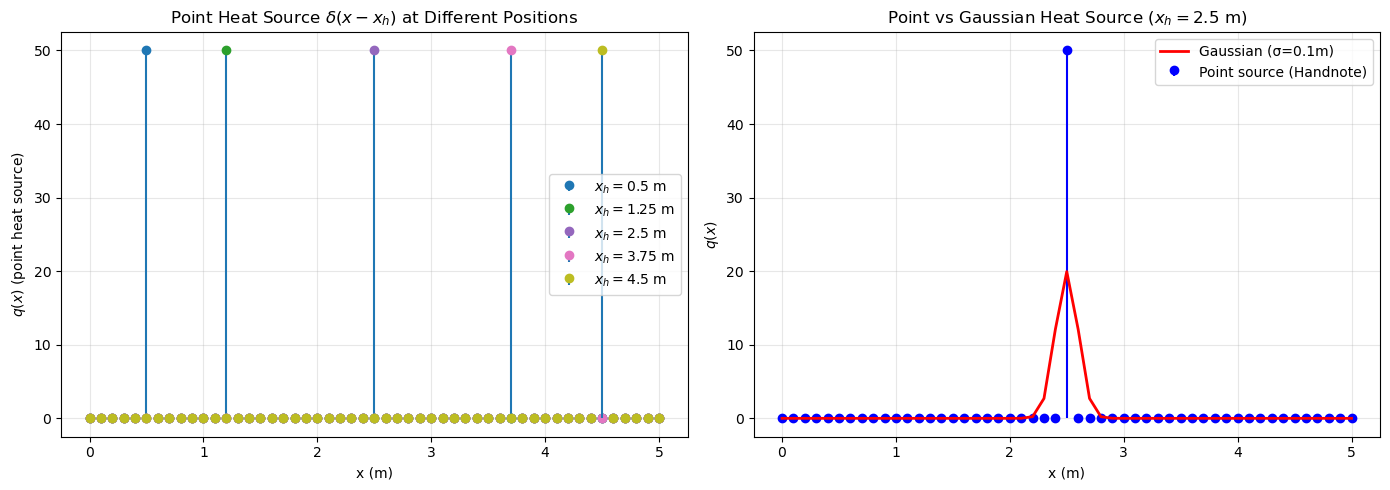

Saved: fig2_heater_profile.png


In [5]:
# === Visualise point heat source profile ===
heater_pos_default = 0.5  # Heater near left wall (insulated side)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Point heat source at different positions
ax = axes[0]
for hp in [0.5, 1.25, 2.5, 3.75, 4.5]:
    profile = make_heater_profile(x, hp, heater_type='point')
    ax.stem(x, profile, linefmt='-', markerfmt='o', basefmt=' ', label=f'$x_h = {hp}$ m')
ax.set_xlabel('x (m)')
ax.set_ylabel('$q(x)$ (point heat source)')
ax.set_title('Point Heat Source $\\delta(x - x_h)$ at Different Positions')
ax.legend()
ax.grid(True, alpha=0.3)

# (b) Compare point vs Gaussian (for reference)
ax = axes[1]
profile_point = make_heater_profile(x, 2.5, heater_type='point')
profile_gauss = make_heater_profile(x, 2.5, heater_type='gaussian')
ax.stem(x, profile_point, linefmt='b-', markerfmt='bo', basefmt=' ', label='Point source (Handnote)')
ax.plot(x, profile_gauss, 'r-', linewidth=2, label='Gaussian (σ=0.1m)')
ax.set_xlabel('x (m)')
ax.set_ylabel('$q(x)$')
ax.set_title('Point vs Gaussian Heat Source ($x_h = 2.5$ m)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig2_heater_profile.png'), dpi=150)
plt.show()
print("Saved: fig2_heater_profile.png")

## 5. Single Simulation Demo

Run a single 1D Bang-Bang simulation with:
- Heater at $x_h = 0.5$ m (near left wall)
- Thermostat at $x_{sensor} = 2.5$ m (room centre)

This demonstrates the full temperature field evolution.

Simulation complete.
  Time points saved: 2401
  Switches: 1
  Final T_sensor: 99.21 °C
  Final T_avg: 149.30 °C


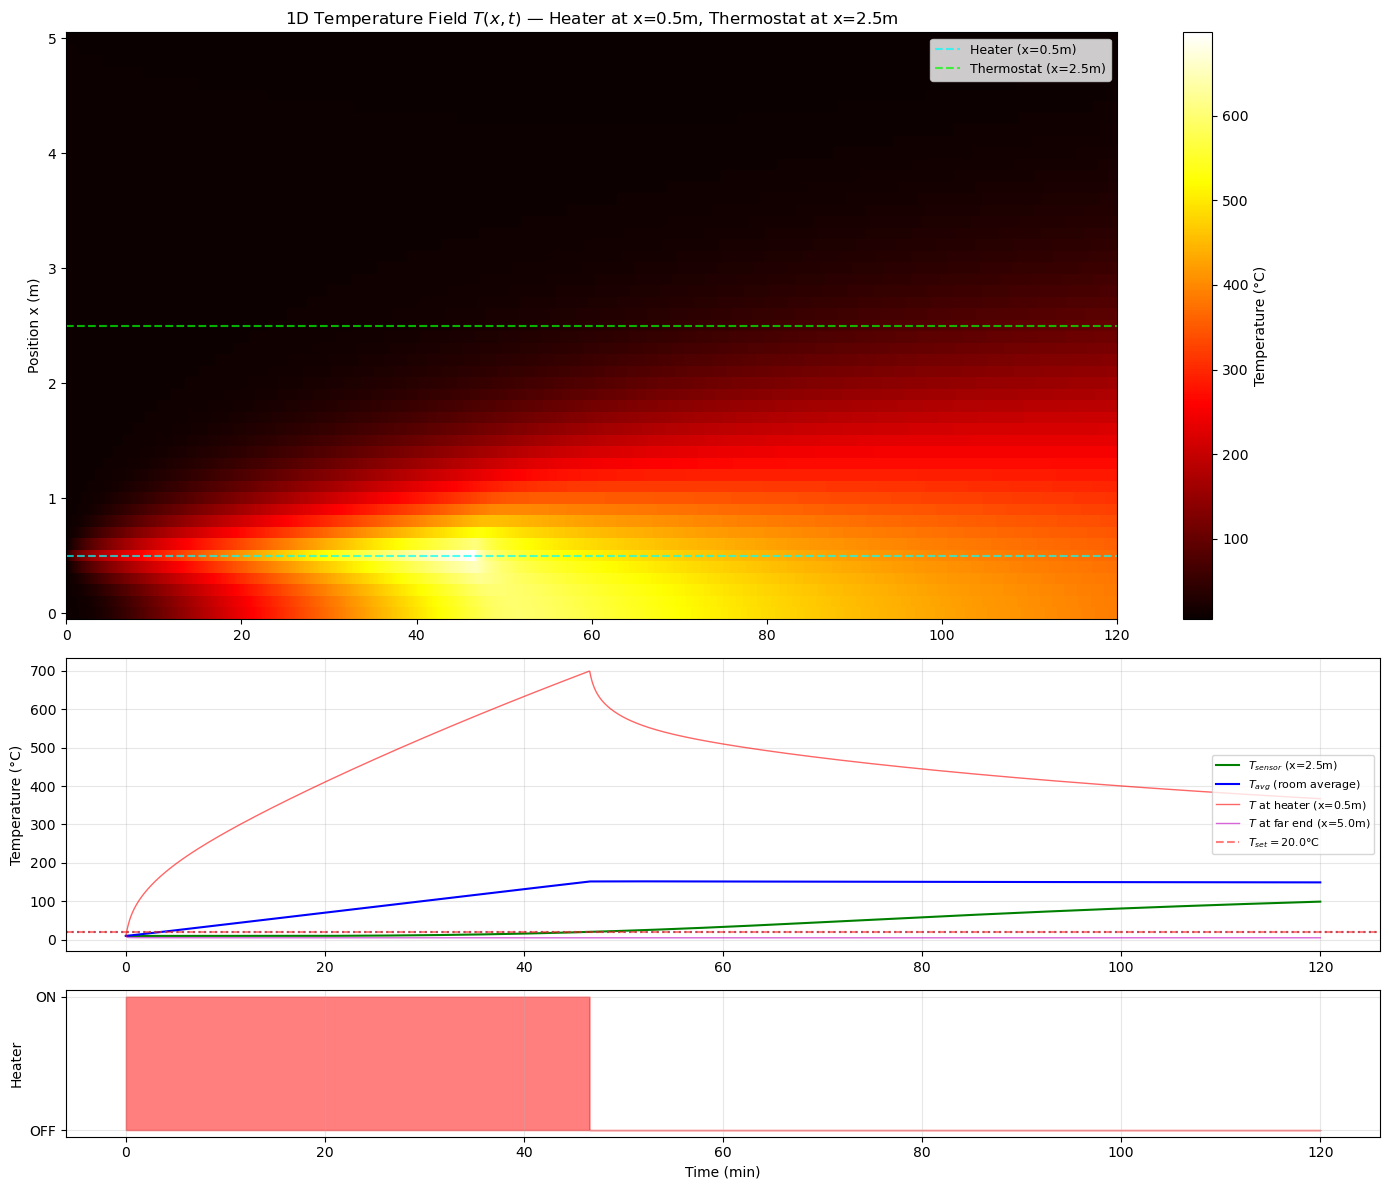

Saved: fig3_demo_simulation.png


In [6]:
# === Single simulation demo ===
result_demo = simulate_1d_bangbang(
    x, alpha, h_wall, T_a, T_initial,
    heater_pos=0.5, sensor_pos=2.5,
    T_set=T_set, delta=delta, U_max=U_max,
    t_end=T_total, dt=0.005
)

print(f"Simulation complete.")
print(f"  Time points saved: {len(result_demo['t'])}")
print(f"  Switches: {result_demo['n_switches']}")
print(f"  Final T_sensor: {result_demo['T_sensor'][-1]:.2f} °C")
print(f"  Final T_avg: {result_demo['T_avg'][-1]:.2f} °C")

# --- Figure 3: Temperature field heatmap ---
fig, axes = plt.subplots(3, 1, figsize=(14, 12), height_ratios=[4, 2, 1])

# (a) Heatmap: T(x, t)
ax = axes[0]
im = ax.pcolormesh(result_demo['t'], x, result_demo['T_field'],
                    shading='auto', cmap='hot')
plt.colorbar(im, ax=ax, label='Temperature (°C)')
ax.axhline(0.5, color='cyan', ls='--', alpha=0.7, label='Heater (x=0.5m)')
ax.axhline(2.5, color='lime', ls='--', alpha=0.7, label='Thermostat (x=2.5m)')
ax.set_ylabel('Position x (m)')
ax.set_title('1D Temperature Field $T(x, t)$ — Heater at x=0.5m, Thermostat at x=2.5m')
ax.legend(loc='upper right', fontsize=9)

# (b) Temperature traces
ax = axes[1]
ax.plot(result_demo['t'], result_demo['T_sensor'], 'g-', linewidth=1.5,
        label='$T_{sensor}$ (x=2.5m)')
ax.plot(result_demo['t'], result_demo['T_avg'], 'b-', linewidth=1.5,
        label='$T_{avg}$ (room average)')
# Temperature at heater and far end
ax.plot(result_demo['t'], result_demo['T_field'][np.argmin(np.abs(x - 0.5)), :],
        'r-', alpha=0.6, linewidth=1, label='$T$ at heater (x=0.5m)')
ax.plot(result_demo['t'], result_demo['T_field'][-1, :],
        'm-', alpha=0.6, linewidth=1, label='$T$ at far end (x=5.0m)')
ax.axhline(T_set, color='red', ls='--', alpha=0.5, label=f'$T_{{set}} = {T_set}$°C')
ax.axhline(T_H, color='orange', ls=':', alpha=0.5)
ax.axhline(T_L, color='purple', ls=':', alpha=0.5)
ax.set_ylabel('Temperature (°C)')
ax.legend(loc='right', fontsize=8)
ax.grid(True, alpha=0.3)

# (c) Heater state
ax = axes[2]
ax.fill_between(result_demo['t'], (result_demo['u'] > 0).astype(float),
                step='mid', alpha=0.5, color='red')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Heater')
ax.set_yticks([0, 1])
ax.set_yticklabels(['OFF', 'ON'])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig3_demo_simulation.png'), dpi=150)
plt.show()
print("Saved: fig3_demo_simulation.png")

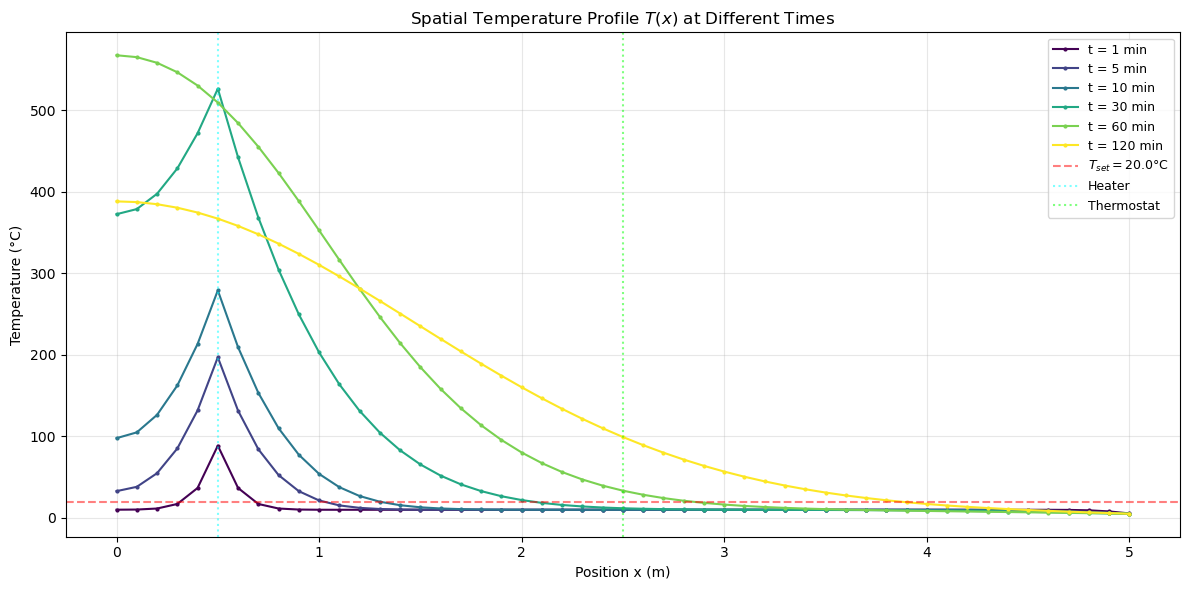

Saved: fig4_spatial_snapshots.png


In [7]:
# --- Figure 4: Spatial temperature snapshots at key times ---
snapshot_times = [1, 5, 10, 30, 60, 120]  # minutes

fig, ax = plt.subplots(figsize=(12, 6))

colors = cm.viridis(np.linspace(0, 1, len(snapshot_times)))
for i, t_snap in enumerate(snapshot_times):
    t_idx = np.argmin(np.abs(result_demo['t'] - t_snap))
    T_snapshot = result_demo['T_field'][:, t_idx]
    ax.plot(x, T_snapshot, 'o-', color=colors[i], markersize=2, linewidth=1.5,
            label=f't = {t_snap} min')

ax.axhline(T_set, color='red', ls='--', alpha=0.5, label=f'$T_{{set}} = {T_set}$°C')
ax.axvline(0.5, color='cyan', ls=':', alpha=0.5, label='Heater')
ax.axvline(2.5, color='lime', ls=':', alpha=0.5, label='Thermostat')

ax.set_xlabel('Position x (m)')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Spatial Temperature Profile $T(x)$ at Different Times')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig4_spatial_snapshots.png'), dpi=150)
plt.show()
print("Saved: fig4_spatial_snapshots.png")

## 6. Thermostat Placement Experiment

### Experiment Design

- **Heater** fixed at $x_h = 0.5$ m (near left wall)
- **Thermostat** position varies: $x_{sensor} \in \{0, 1.25, 2.5, 3.75, 5.0\}$ m
- **Control**: Bang-Bang with $\delta = 0.5$°C
- **Simulation time**: 120 min

### What we expect:
- $x_{sensor} = 0$ (near heater): quick response, but far end stays cold
- $x_{sensor} = 5.0$ (far from heater): slow response, heater near end overheats
- Somewhere in the middle: best compromise?

In [8]:
# === Thermostat Placement Experiment ===
heater_pos = 0.5
sensor_positions = [0.0, 1.25, 2.5, 3.75, 5.0]

results_placement = {}

print("Running thermostat placement experiments...")
print(f"  Heater at x = {heater_pos} m")
print(f"  δ = {delta}°C, T_set = {T_set}°C")
print()

for sp in sensor_positions:
    print(f"  Simulating sensor at x = {sp:.2f} m ...", end=" ")
    res = simulate_1d_bangbang(
        x, alpha, h_wall, T_a, T_initial,
        heater_pos=heater_pos, sensor_pos=sp,
        T_set=T_set, delta=delta, U_max=U_max,
        t_end=T_total, dt=0.005
    )
    results_placement[sp] = res
    print(f"done. Switches = {res['n_switches']}")

print("\nAll simulations complete.")

Running thermostat placement experiments...
  Heater at x = 0.5 m
  δ = 0.5°C, T_set = 20.0°C

  Simulating sensor at x = 0.00 m ... done. Switches = 1
  Simulating sensor at x = 1.25 m ... done. Switches = 1
  Simulating sensor at x = 2.50 m ... done. Switches = 1
  Simulating sensor at x = 3.75 m ... done. Switches = 1
  Simulating sensor at x = 5.00 m ... done. Switches = 0

All simulations complete.


In [9]:
# === Compute metrics for each placement ===

def compute_metrics(result, T_set, T_total):
    """Compute performance metrics from simulation result."""
    t = result['t']
    T_sensor = result['T_sensor']
    T_avg = result['T_avg']
    u = result['u']
    T_field = result['T_field']
    
    dt = t[1] - t[0] if len(t) > 1 else 1.0
    
    # Energy: ∫u(t)dt
    energy = np.trapz(u, t)
    
    # RMSE at sensor
    rmse_sensor = np.sqrt(np.mean((T_sensor - T_set)**2))
    
    # RMSE of room average
    rmse_avg = np.sqrt(np.mean((T_avg - T_set)**2))
    
    # Max spatial temperature difference (in steady state, last 20%)
    n_steady = max(1, len(t) // 5)
    T_field_steady = T_field[:, -n_steady:]
    max_spatial_diff = np.mean(np.max(T_field_steady, axis=0) - np.min(T_field_steady, axis=0))
    
    # Max overshoot (room average above T_set)
    max_overshoot = np.max(T_avg) - T_set
    
    # Settling time (room average enters T_set ± 1°C and stays)
    settled = np.abs(T_avg - T_set) < 1.0
    settling_time = T_total
    for i in range(len(settled)):
        if settled[i] and np.all(settled[i:]):
            settling_time = t[i]
            break
    
    # Number of switches
    n_switches = result['n_switches']
    
    return {
        'energy': energy,
        'rmse_sensor': rmse_sensor,
        'rmse_avg': rmse_avg,
        'max_spatial_diff': max_spatial_diff,
        'max_overshoot': max_overshoot,
        'settling_time': settling_time,
        'n_switches': n_switches,
    }

# Compute metrics for all placements
metrics_table = {}
for sp, res in results_placement.items():
    metrics_table[sp] = compute_metrics(res, T_set, T_total)

# Print table
print("=" * 100)
print("Thermostat Placement: Performance Metrics")
print(f"  Heater at x = {heater_pos} m, δ = {delta}°C, T_set = {T_set}°C, Sim = {T_total} min")
print("=" * 100)
print(f"{'x_sensor':>10} {'Energy':>10} {'RMSE_sens':>10} {'RMSE_avg':>10} "
      f"{'ΔT_spatial':>10} {'Overshoot':>10} {'t_settle':>10} {'Switches':>10}")
print("-" * 100)

for sp in sensor_positions:
    m = metrics_table[sp]
    print(f"{sp:>10.2f} {m['energy']:>10.1f} {m['rmse_sensor']:>10.3f} {m['rmse_avg']:>10.3f} "
          f"{m['max_spatial_diff']:>10.2f} {m['max_overshoot']:>10.2f} "
          f"{m['settling_time']:>10.1f} {m['n_switches']:>10d}")

Thermostat Placement: Performance Metrics
  Heater at x = 0.5 m, δ = 0.5°C, T_set = 20.0°C, Sim = 120.0 min
  x_sensor     Energy  RMSE_sens   RMSE_avg ΔT_spatial  Overshoot   t_settle   Switches
----------------------------------------------------------------------------------------------------
      0.00       55.1     28.197      1.099      33.43       0.92        3.1          1
      1.25      123.4     35.804     13.832      69.49      14.93      120.0          1
      2.50      698.6     37.708    111.886     406.52     131.97      120.0          1
      3.75     1600.9      8.651    197.949    1132.63     313.58      120.0          1
      5.00     1800.0     14.880    201.574    1208.60     353.24      120.0          0


## 7. Placement Comparison Visualisation

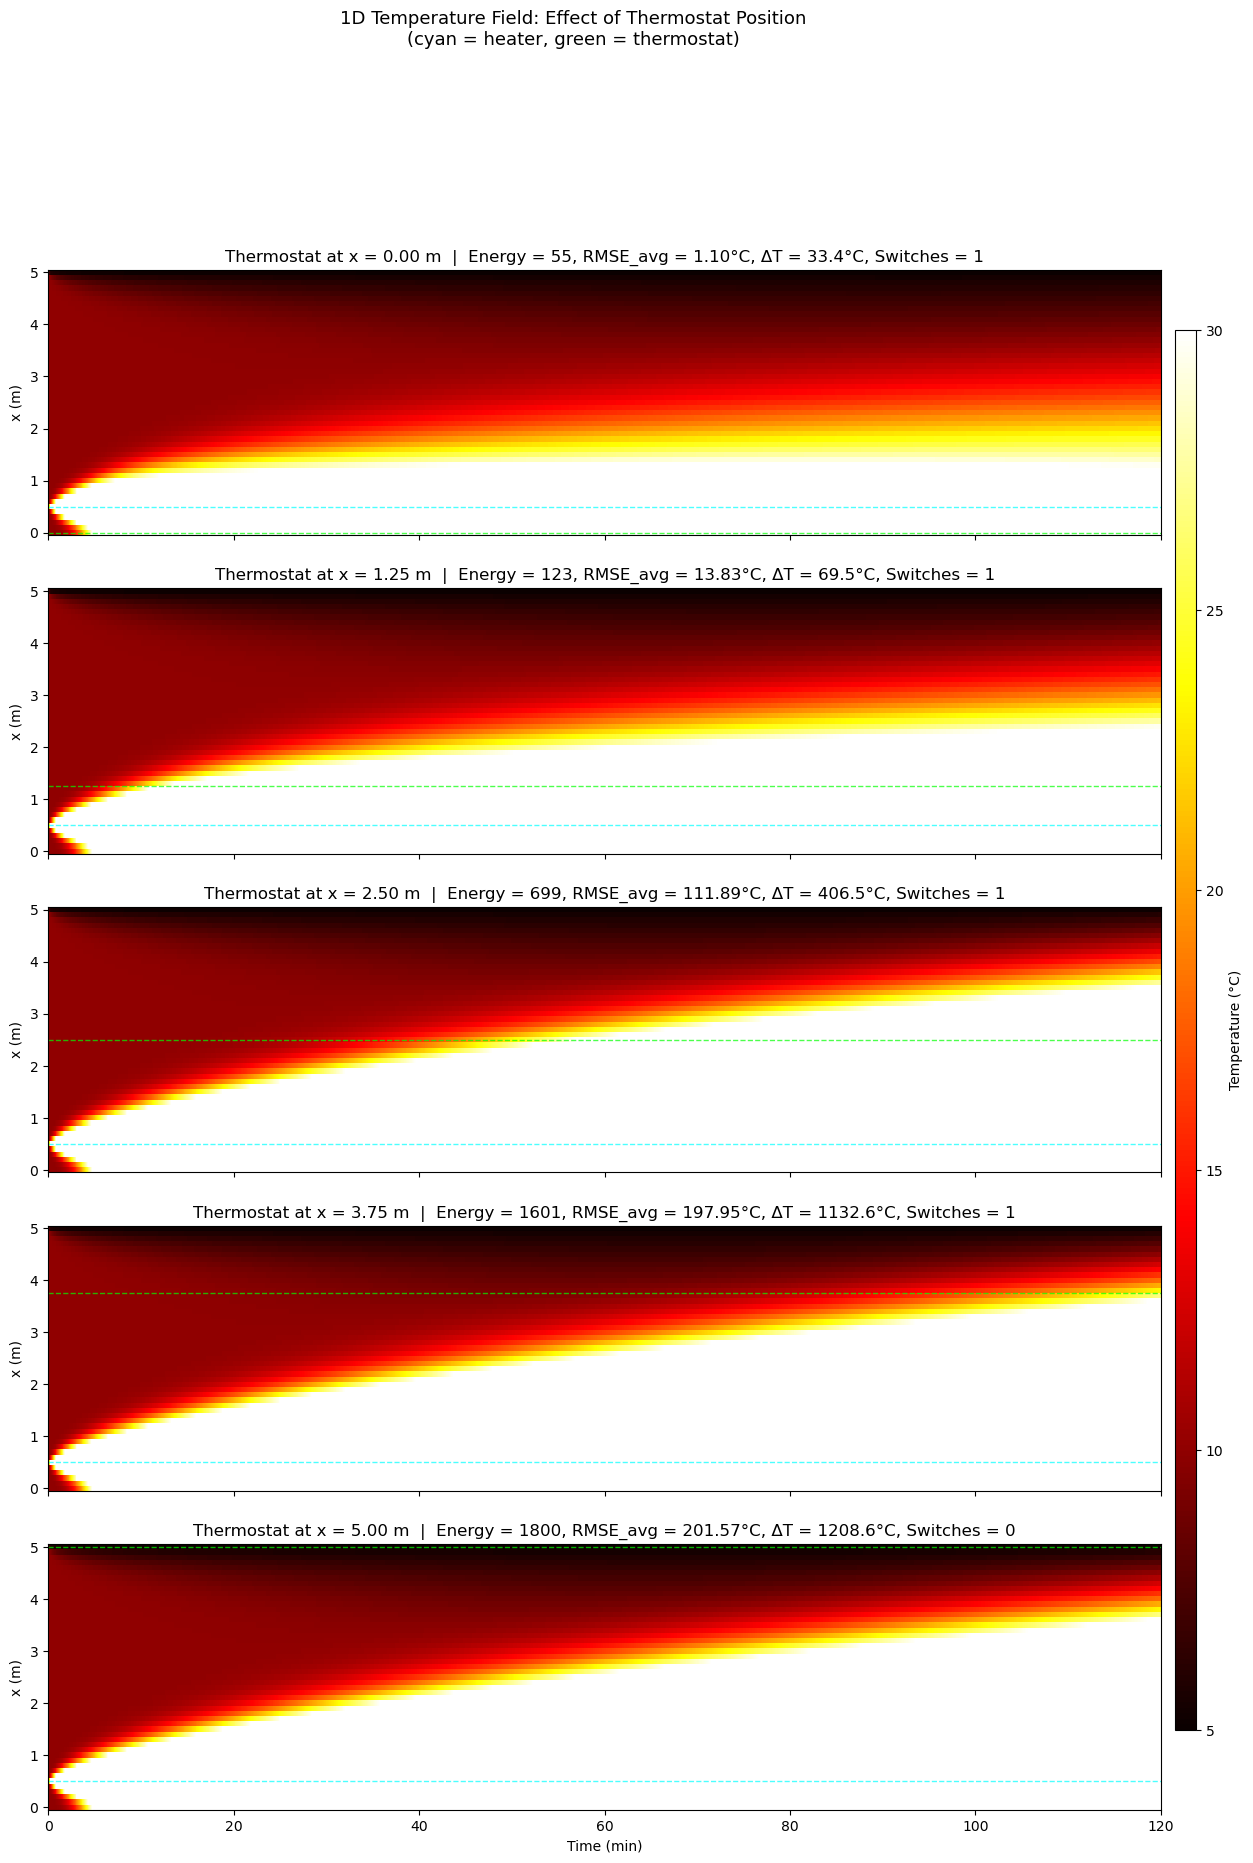

Saved: fig5_heatmaps_all_positions.png


In [10]:
# --- Figure 5: Heatmaps for each thermostat position ---
fig, axes = plt.subplots(len(sensor_positions), 1,
                          figsize=(14, 4 * len(sensor_positions)), sharex=True)

for idx, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    ax = axes[idx]
    im = ax.pcolormesh(res['t'], x, res['T_field'], shading='auto', cmap='hot',
                        vmin=T_a, vmax=T_set + 10)
    ax.axhline(heater_pos, color='cyan', ls='--', alpha=0.7, linewidth=1)
    ax.axhline(sp, color='lime', ls='--', alpha=0.7, linewidth=1)
    m = metrics_table[sp]
    ax.set_ylabel('x (m)')
    ax.set_title(f'Thermostat at x = {sp:.2f} m  |  '
                 f'Energy = {m["energy"]:.0f}, RMSE_avg = {m["rmse_avg"]:.2f}°C, '
                 f'ΔT = {m["max_spatial_diff"]:.1f}°C, Switches = {m["n_switches"]}')

axes[-1].set_xlabel('Time (min)')
# Shared colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Temperature (°C)')

plt.suptitle('1D Temperature Field: Effect of Thermostat Position\n'
             '(cyan = heater, green = thermostat)', fontsize=13, y=1.01)
plt.savefig(os.path.join(RESULT_DIR, 'fig5_heatmaps_all_positions.png'),
            dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig5_heatmaps_all_positions.png")

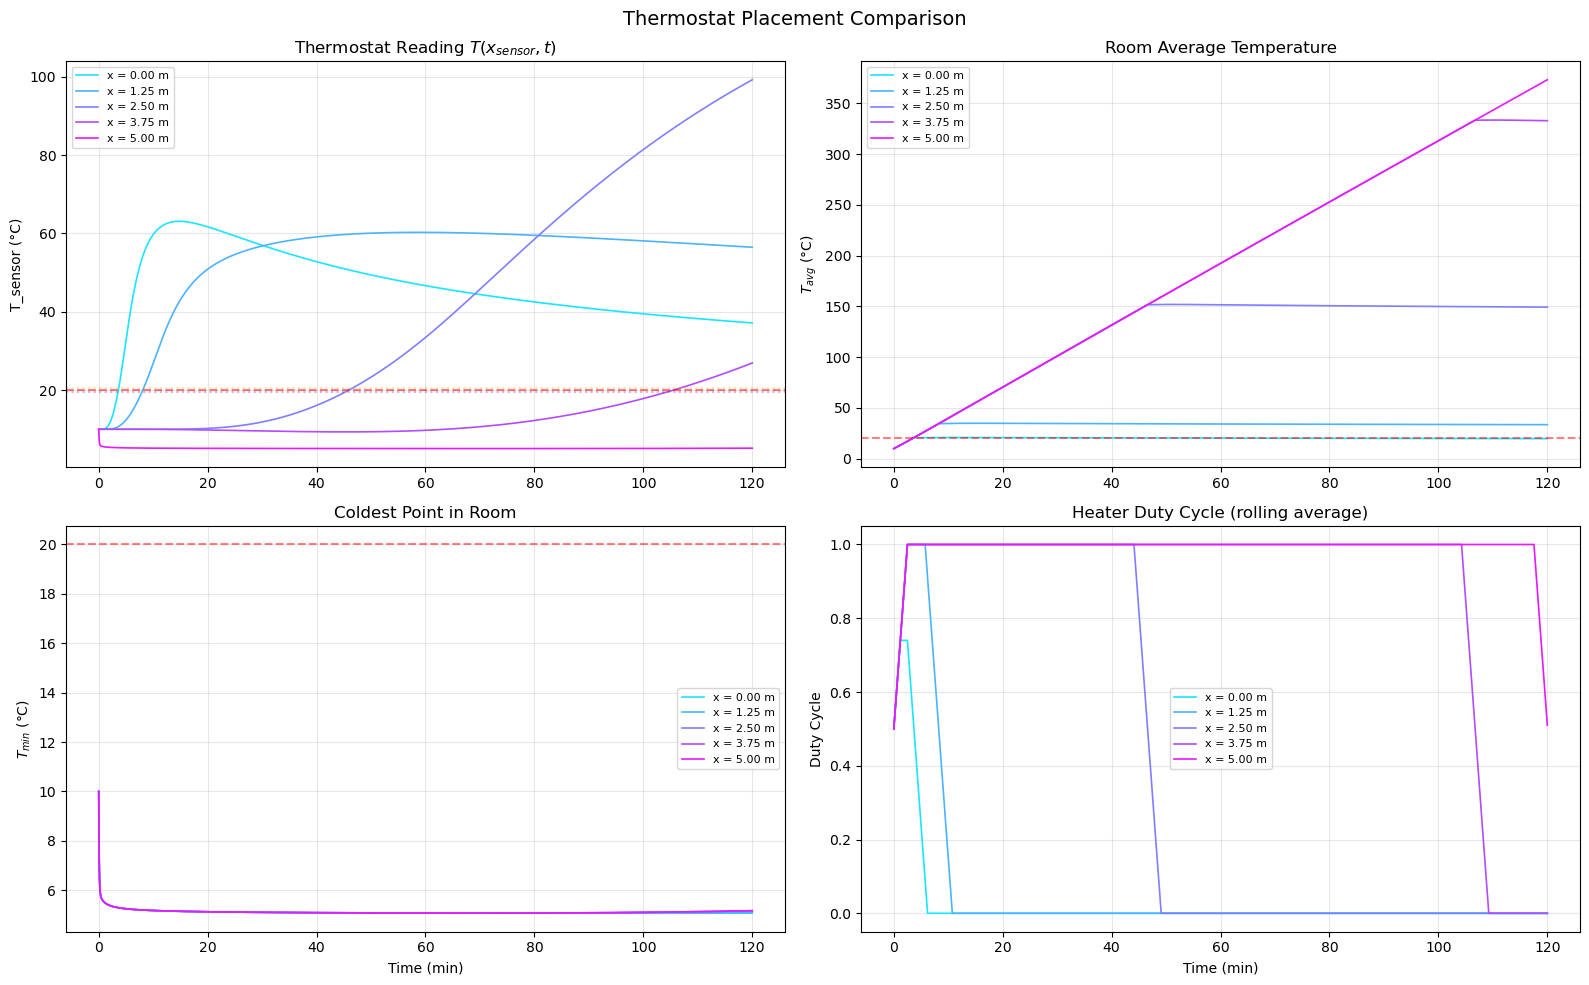

Saved: fig6_placement_comparison.png


In [11]:
# --- Figure 6: Sensor temperature & room average comparison ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

colors_pos = cm.cool(np.linspace(0.1, 0.9, len(sensor_positions)))

# (a) Sensor temperature
ax = axes[0, 0]
for i, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    ax.plot(res['t'], res['T_sensor'], color=colors_pos[i], linewidth=1.2,
            label=f'x = {sp:.2f} m')
ax.axhline(T_set, color='red', ls='--', alpha=0.5)
ax.axhline(T_H, color='orange', ls=':', alpha=0.3)
ax.axhline(T_L, color='purple', ls=':', alpha=0.3)
ax.set_ylabel('T_sensor (°C)')
ax.set_title('Thermostat Reading $T(x_{sensor}, t)$')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (b) Room average temperature
ax = axes[0, 1]
for i, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    ax.plot(res['t'], res['T_avg'], color=colors_pos[i], linewidth=1.2,
            label=f'x = {sp:.2f} m')
ax.axhline(T_set, color='red', ls='--', alpha=0.5)
ax.set_ylabel('$T_{avg}$ (°C)')
ax.set_title('Room Average Temperature')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (c) Coldest point temperature
ax = axes[1, 0]
for i, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    T_min_t = np.min(res['T_field'], axis=0)
    ax.plot(res['t'], T_min_t, color=colors_pos[i], linewidth=1.2,
            label=f'x = {sp:.2f} m')
ax.axhline(T_set, color='red', ls='--', alpha=0.5)
ax.set_xlabel('Time (min)')
ax.set_ylabel('$T_{min}$ (°C)')
ax.set_title('Coldest Point in Room')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (d) Control input
ax = axes[1, 1]
for i, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    heater_on = (res['u'] > 0).astype(float)
    # Running duty cycle (fraction of time heater is ON)
    window = min(100, len(heater_on) // 5)
    if window > 0:
        duty_cycle = np.convolve(heater_on, np.ones(window)/window, mode='same')
        ax.plot(res['t'], duty_cycle, color=colors_pos[i], linewidth=1.2,
                label=f'x = {sp:.2f} m')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Duty Cycle')
ax.set_title('Heater Duty Cycle (rolling average)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle('Thermostat Placement Comparison', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig6_placement_comparison.png'), dpi=150)
plt.show()
print("Saved: fig6_placement_comparison.png")

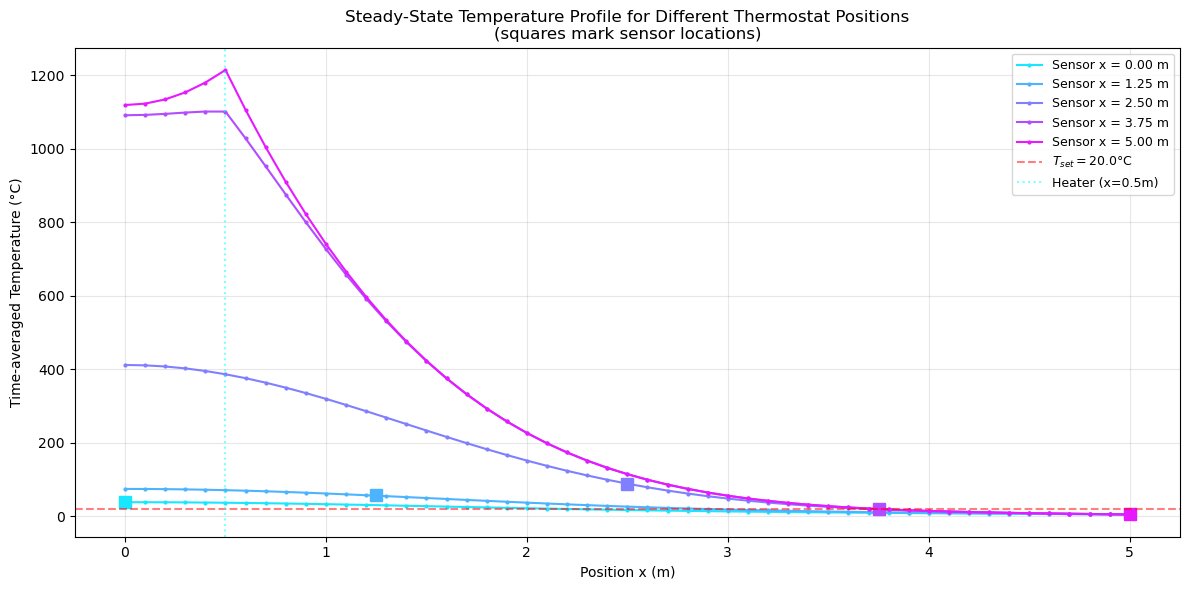

Saved: fig7_steady_state_profiles.png


In [12]:
# --- Figure 7: Steady-state spatial profiles for each sensor position ---
fig, ax = plt.subplots(figsize=(12, 6))

for i, sp in enumerate(sensor_positions):
    res = results_placement[sp]
    # Average over last 20% of simulation (steady state)
    n_steady = max(1, res['T_field'].shape[1] // 5)
    T_steady_avg = np.mean(res['T_field'][:, -n_steady:], axis=1)
    ax.plot(x, T_steady_avg, 'o-', color=colors_pos[i], markersize=2, linewidth=1.5,
            label=f'Sensor x = {sp:.2f} m')
    # Mark sensor position
    sensor_idx = np.argmin(np.abs(x - sp))
    ax.plot(sp, T_steady_avg[sensor_idx], 's', color=colors_pos[i], markersize=8)

ax.axhline(T_set, color='red', ls='--', alpha=0.5, label=f'$T_{{set}} = {T_set}$°C')
ax.axvline(heater_pos, color='cyan', ls=':', alpha=0.5, label=f'Heater (x={heater_pos}m)')

ax.set_xlabel('Position x (m)')
ax.set_ylabel('Time-averaged Temperature (°C)')
ax.set_title('Steady-State Temperature Profile for Different Thermostat Positions\n'
             '(squares mark sensor locations)')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig7_steady_state_profiles.png'), dpi=150)
plt.show()
print("Saved: fig7_steady_state_profiles.png")

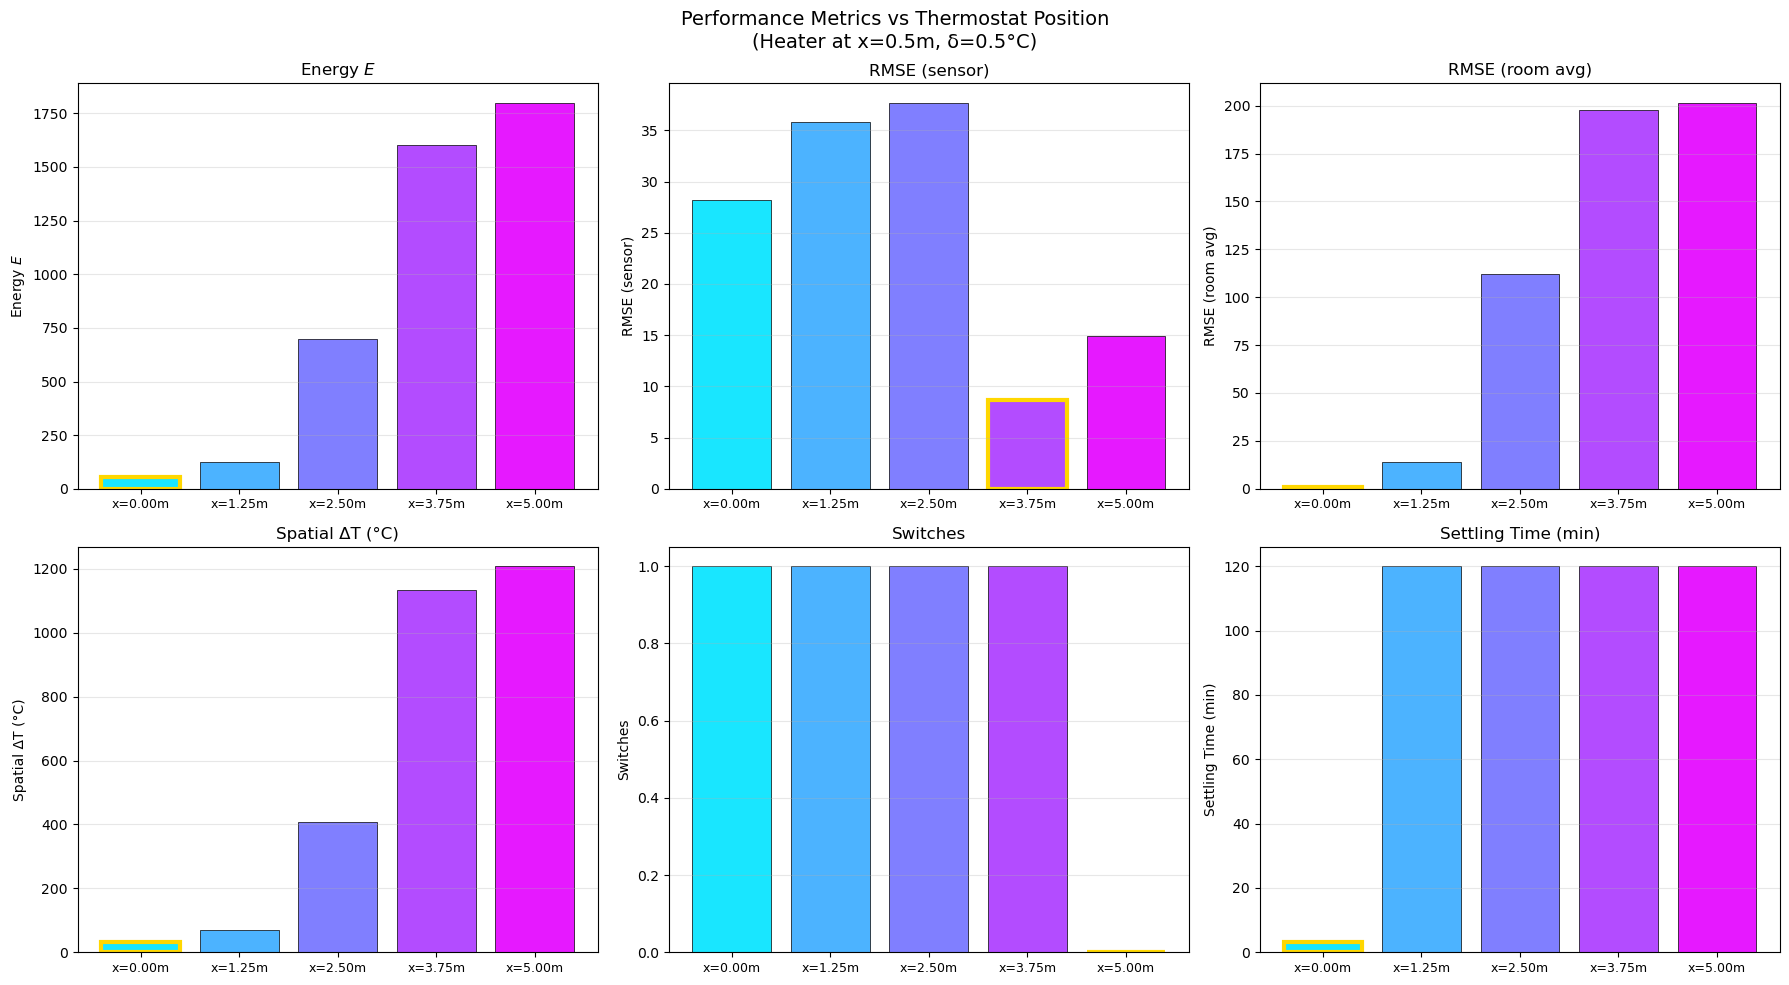

Saved: fig8_metrics_bar_charts.png


In [13]:
# --- Figure 8: Metrics bar charts ---
metric_names = ['energy', 'rmse_sensor', 'rmse_avg', 'max_spatial_diff', 'n_switches', 'settling_time']
metric_labels = ['Energy $E$', 'RMSE (sensor)', 'RMSE (room avg)', 
                 'Spatial ΔT (°C)', 'Switches', 'Settling Time (min)']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

x_bar = np.arange(len(sensor_positions))
bar_labels = [f'x={sp:.2f}m' for sp in sensor_positions]

for idx, (key, label) in enumerate(zip(metric_names, metric_labels)):
    ax = axes[idx]
    values = [metrics_table[sp][key] for sp in sensor_positions]
    bars = ax.bar(x_bar, values, color=colors_pos, edgecolor='black', linewidth=0.5)
    ax.set_xticks(x_bar)
    ax.set_xticklabels(bar_labels, fontsize=9)
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight best value
    if key == 'energy':
        best_idx = np.argmin(values)
    elif key in ['rmse_sensor', 'rmse_avg', 'max_spatial_diff', 'settling_time']:
        best_idx = np.argmin(values)
    else:  # n_switches: fewer is better
        best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.suptitle('Performance Metrics vs Thermostat Position\n'
             f'(Heater at x={heater_pos}m, δ={delta}°C)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig8_metrics_bar_charts.png'), dpi=150)
plt.show()
print("Saved: fig8_metrics_bar_charts.png")

## 8. Optimal Thermostat Position Search

We define a **combined cost** (analogous to Week 1's $J(\delta)$):

$$J(x_{sensor}) = E(x_{sensor}) + \lambda \cdot \text{RMSE}_{avg}^2(x_{sensor}) \cdot T_{total}$$

and sweep $x_{sensor}$ over a finer grid to find the optimal placement.

In [14]:
# === Finer sensor position sweep ===
sensor_positions_fine = np.linspace(0.0, 5.0, 11)  # 11 positions

metrics_fine = {}

print("Running fine sensor position sweep (11 positions)...")
for sp in sensor_positions_fine:
    print(f"  x_sensor = {sp:.2f} m ...", end=" ")
    res = simulate_1d_bangbang(
        x, alpha, h_wall, T_a, T_initial,
        heater_pos=heater_pos, sensor_pos=sp,
        T_set=T_set, delta=delta, U_max=U_max,
        t_end=T_total, dt=0.005
    )
    metrics_fine[sp] = compute_metrics(res, T_set, T_total)
    print(f"RMSE_avg = {metrics_fine[sp]['rmse_avg']:.3f}, E = {metrics_fine[sp]['energy']:.0f}")

print("Done.")

Running fine sensor position sweep (11 positions)...
  x_sensor = 0.00 m ... RMSE_avg = 1.099, E = 55
  x_sensor = 0.50 m ... RMSE_avg = 8.242, E = 18
  x_sensor = 1.00 m ... RMSE_avg = 3.880, E = 72
  x_sensor = 1.50 m ... RMSE_avg = 32.338, E = 221
  x_sensor = 2.00 m ... RMSE_avg = 69.897, E = 432
  x_sensor = 2.50 m ... RMSE_avg = 111.886, E = 699
  x_sensor = 3.00 m ... RMSE_avg = 153.976, E = 1025
  x_sensor = 3.50 m ... RMSE_avg = 189.063, E = 1422
  x_sensor = 4.00 m ... RMSE_avg = 201.574, E = 1800
  x_sensor = 4.50 m ... RMSE_avg = 201.574, E = 1800
  x_sensor = 5.00 m ... RMSE_avg = 201.574, E = 1800
Done.


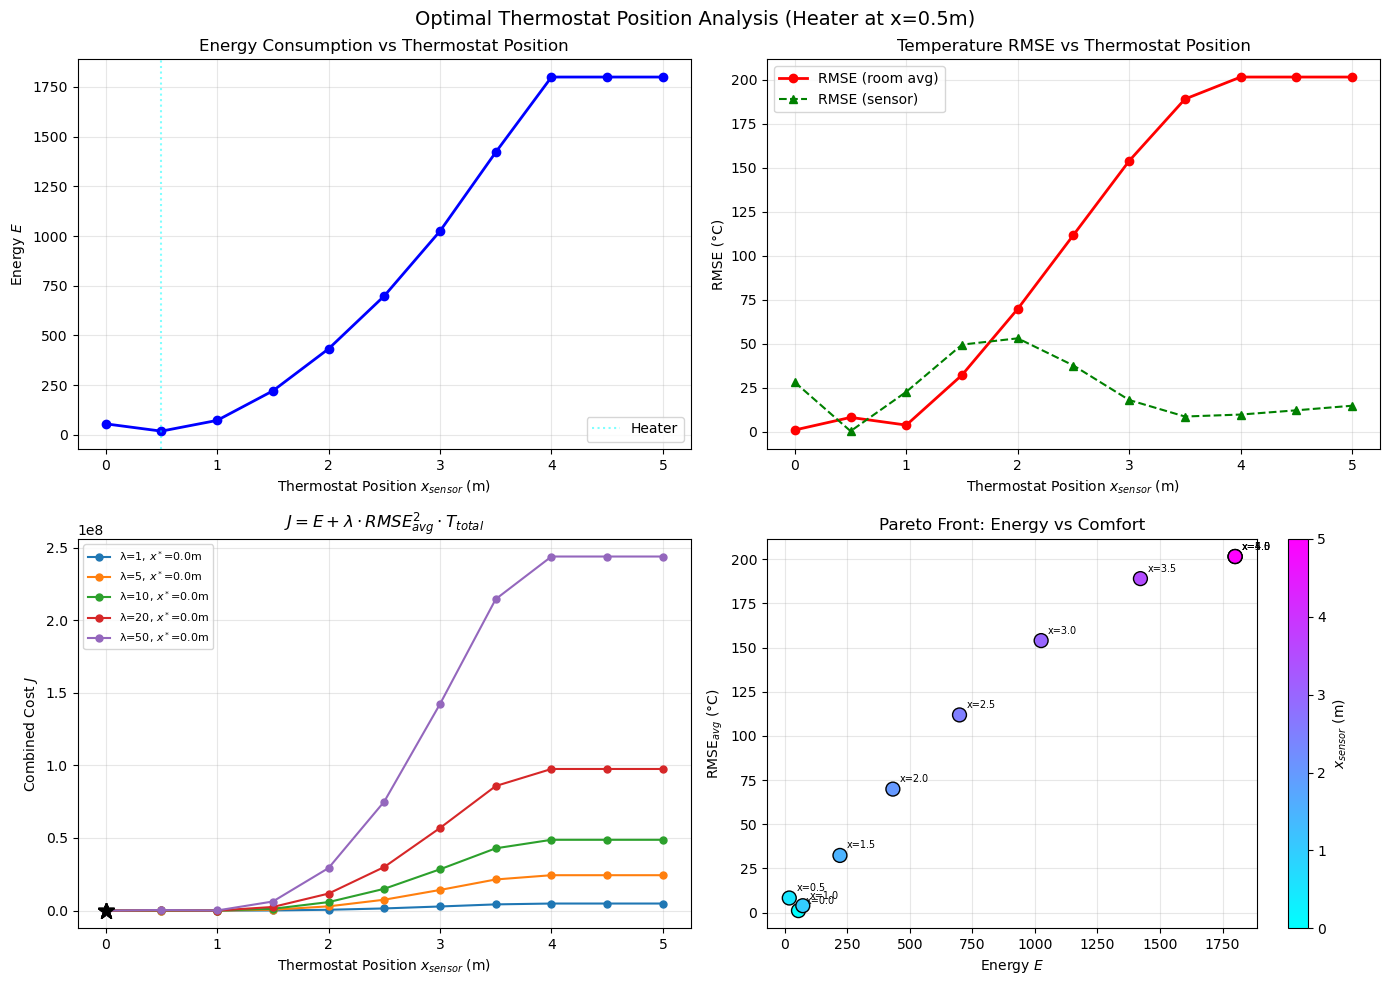

Saved: fig9_optimal_position.png


In [15]:
# --- Figure 9: Optimal position analysis ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sp_arr = np.array(list(metrics_fine.keys()))
energy_arr = np.array([metrics_fine[sp]['energy'] for sp in sp_arr])
rmse_avg_arr = np.array([metrics_fine[sp]['rmse_avg'] for sp in sp_arr])
rmse_sens_arr = np.array([metrics_fine[sp]['rmse_sensor'] for sp in sp_arr])
spatial_diff_arr = np.array([metrics_fine[sp]['max_spatial_diff'] for sp in sp_arr])

# (a) Energy vs position
ax = axes[0, 0]
ax.plot(sp_arr, energy_arr, 'bo-', linewidth=2, markersize=6)
ax.set_xlabel('Thermostat Position $x_{sensor}$ (m)')
ax.set_ylabel('Energy $E$')
ax.set_title('Energy Consumption vs Thermostat Position')
ax.axvline(heater_pos, color='cyan', ls=':', alpha=0.5, label='Heater')
ax.legend()
ax.grid(True, alpha=0.3)

# (b) RMSE_avg vs position
ax = axes[0, 1]
ax.plot(sp_arr, rmse_avg_arr, 'ro-', linewidth=2, markersize=6, label='RMSE (room avg)')
ax.plot(sp_arr, rmse_sens_arr, 'g^--', linewidth=1.5, markersize=6, label='RMSE (sensor)')
ax.set_xlabel('Thermostat Position $x_{sensor}$ (m)')
ax.set_ylabel('RMSE (°C)')
ax.set_title('Temperature RMSE vs Thermostat Position')
ax.legend()
ax.grid(True, alpha=0.3)

# (c) Combined cost J for different lambda
ax = axes[1, 0]
for lam in [1, 5, 10, 20, 50]:
    J = energy_arr + lam * rmse_avg_arr**2 * T_total
    opt_idx = np.argmin(J)
    ax.plot(sp_arr, J, 'o-', linewidth=1.5, markersize=5,
            label=f'λ={lam}, $x^*$={sp_arr[opt_idx]:.1f}m')
    ax.plot(sp_arr[opt_idx], J[opt_idx], 'k*', markersize=12)
ax.set_xlabel('Thermostat Position $x_{sensor}$ (m)')
ax.set_ylabel('Combined Cost $J$')
ax.set_title('$J = E + \\lambda \\cdot RMSE_{avg}^2 \\cdot T_{total}$')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (d) Pareto front: Energy vs RMSE_avg
ax = axes[1, 1]
ax.scatter(energy_arr, rmse_avg_arr, c=sp_arr, cmap='cool', s=100,
           edgecolors='black', zorder=5)
for i, sp in enumerate(sp_arr):
    ax.annotate(f'x={sp:.1f}', (energy_arr[i], rmse_avg_arr[i]),
                textcoords='offset points', xytext=(5, 5), fontsize=7)
ax.set_xlabel('Energy $E$')
ax.set_ylabel('RMSE$_{avg}$ (°C)')
ax.set_title('Pareto Front: Energy vs Comfort')
cb = plt.colorbar(ax.collections[0], ax=ax, label='$x_{sensor}$ (m)')
ax.grid(True, alpha=0.3)

plt.suptitle(f'Optimal Thermostat Position Analysis (Heater at x={heater_pos}m)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig9_optimal_position.png'), dpi=150)
plt.show()
print("Saved: fig9_optimal_position.png")

## 9. Effect of Hysteresis Band $\delta$ on 1D Performance

In Week 1 we studied optimal $\delta$ for the 0D model. Now we explore how $\delta$ interacts with thermostat placement in 1D.

In [16]:
# === Delta × Position cross-experiment ===
delta_values = [0.25, 0.5, 1.0, 2.0]
sensor_positions_cross = [0.0, 1.25, 2.5, 3.75, 5.0]

cross_results = {}  # (delta, sensor_pos) -> metrics

print("Running δ × position cross-experiment...")
for d in delta_values:
    for sp in sensor_positions_cross:
        print(f"  δ = {d}, x_sensor = {sp:.2f} m ...", end=" ")
        res = simulate_1d_bangbang(
            x, alpha, h_wall, T_a, T_initial,
            heater_pos=heater_pos, sensor_pos=sp,
            T_set=T_set, delta=d, U_max=U_max,
            t_end=T_total, dt=0.005
        )
        cross_results[(d, sp)] = compute_metrics(res, T_set, T_total)
        print(f"done.")

print("Cross-experiment complete.")

Running δ × position cross-experiment...
  δ = 0.25, x_sensor = 0.00 m ... done.
  δ = 0.25, x_sensor = 1.25 m ... done.
  δ = 0.25, x_sensor = 2.50 m ... done.
  δ = 0.25, x_sensor = 3.75 m ... done.
  δ = 0.25, x_sensor = 5.00 m ... done.
  δ = 0.5, x_sensor = 0.00 m ... done.
  δ = 0.5, x_sensor = 1.25 m ... done.
  δ = 0.5, x_sensor = 2.50 m ... done.
  δ = 0.5, x_sensor = 3.75 m ... done.
  δ = 0.5, x_sensor = 5.00 m ... done.
  δ = 1.0, x_sensor = 0.00 m ... done.
  δ = 1.0, x_sensor = 1.25 m ... done.
  δ = 1.0, x_sensor = 2.50 m ... done.
  δ = 1.0, x_sensor = 3.75 m ... done.
  δ = 1.0, x_sensor = 5.00 m ... done.
  δ = 2.0, x_sensor = 0.00 m ... done.
  δ = 2.0, x_sensor = 1.25 m ... done.
  δ = 2.0, x_sensor = 2.50 m ... done.
  δ = 2.0, x_sensor = 3.75 m ... done.
  δ = 2.0, x_sensor = 5.00 m ... done.
Cross-experiment complete.


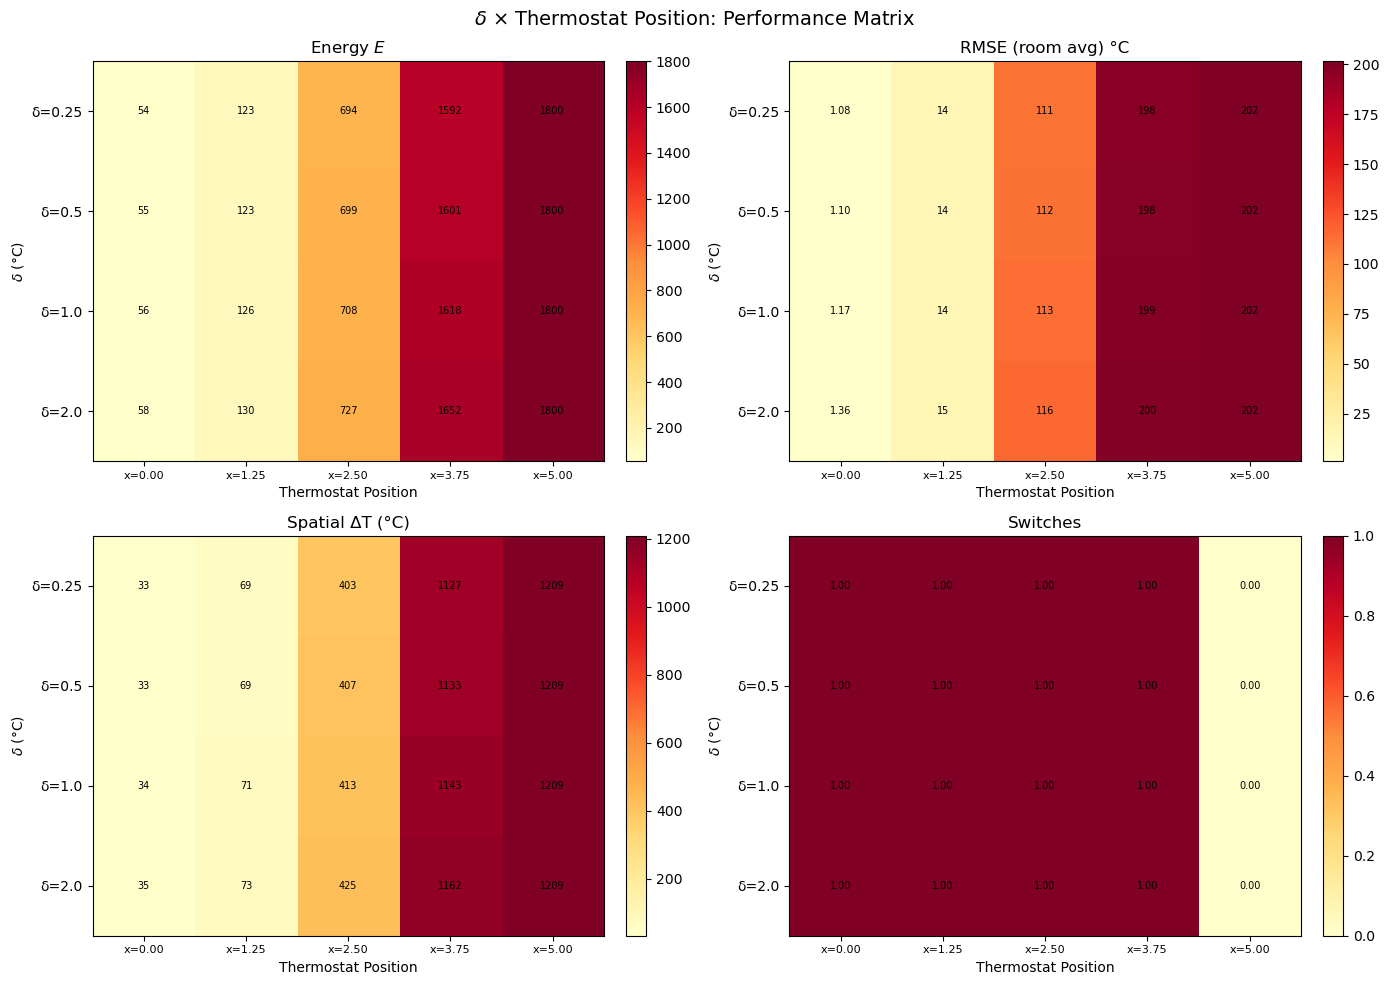

Saved: fig10_delta_position_matrix.png


In [17]:
# --- Figure 10: δ × Position heatmap matrices ---
metric_keys_cross = ['energy', 'rmse_avg', 'max_spatial_diff', 'n_switches']
metric_labels_cross = ['Energy $E$', 'RMSE (room avg) °C', 'Spatial ΔT (°C)', 'Switches']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (key, label) in enumerate(zip(metric_keys_cross, metric_labels_cross)):
    ax = axes[idx]
    matrix = np.zeros((len(delta_values), len(sensor_positions_cross)))
    for i, d in enumerate(delta_values):
        for j, sp in enumerate(sensor_positions_cross):
            matrix[i, j] = cross_results[(d, sp)][key]
    
    im = ax.imshow(matrix, aspect='auto', cmap='YlOrRd')
    ax.set_xticks(range(len(sensor_positions_cross)))
    ax.set_xticklabels([f'x={sp:.2f}' for sp in sensor_positions_cross], fontsize=8)
    ax.set_yticks(range(len(delta_values)))
    ax.set_yticklabels([f'δ={d}' for d in delta_values])
    ax.set_xlabel('Thermostat Position')
    ax.set_ylabel('$\\delta$ (°C)')
    ax.set_title(label)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Annotate
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            fmt = f'{val:.0f}' if val > 10 else f'{val:.2f}'
            ax.text(j, i, fmt, ha='center', va='center', fontsize=7, color='black')

plt.suptitle('$\\delta$ × Thermostat Position: Performance Matrix', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig10_delta_position_matrix.png'), dpi=150)
plt.show()
print("Saved: fig10_delta_position_matrix.png")

## 10. Comparison with 0D Model

How does the 1D model change our conclusions from Week 1?

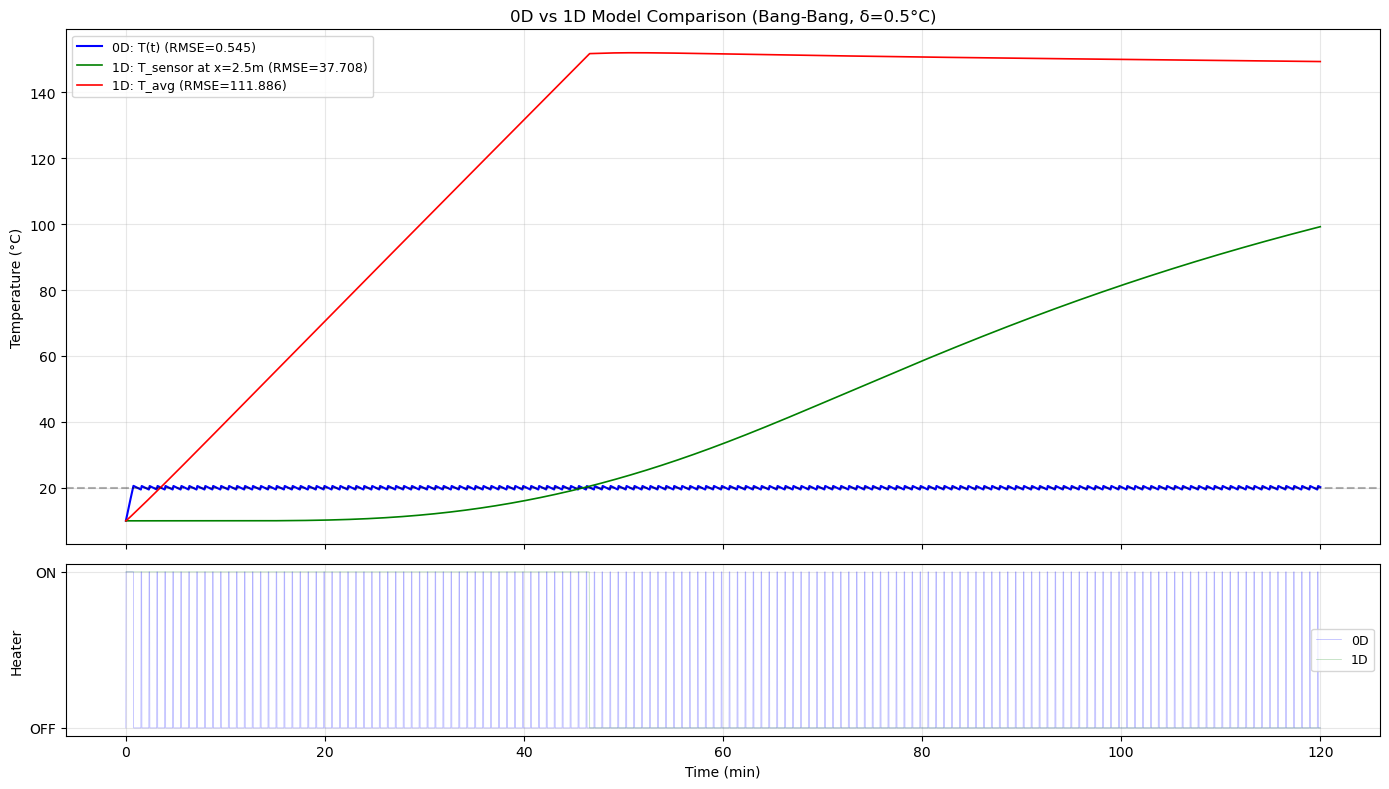


=== 0D vs 1D Summary ===
Metric                         0D     1D (x=2.5m)
--------------------------------------------------
Energy                      190.2           698.6
RMSE                        0.545         111.886
Switches                      299               1
Spatial ΔT                    N/A          406.52 °C

Saved: fig11_0d_vs_1d.png


In [18]:
# === 0D vs 1D comparison ===

# 0D simulation (from Week 1)
def simulate_0d_bangbang(T_a, T_initial, T_set, delta, U_max, k, t_end, dt=0.01):
    """Simulate 0D Bang-Bang for comparison."""
    T_H = T_set + delta
    T_L = T_set - delta
    t_arr = np.arange(0, t_end + dt, dt)
    T_arr = np.zeros_like(t_arr)
    u_arr = np.zeros_like(t_arr)
    T_arr[0] = T_initial
    heater_on = True
    n_switches = 0
    
    for i in range(1, len(t_arr)):
        T_prev = T_arr[i-1]
        if heater_on and T_prev >= T_H:
            heater_on = False
            n_switches += 1
        elif not heater_on and T_prev <= T_L:
            heater_on = True
            n_switches += 1
        
        u = U_max if heater_on else 0.0
        u_arr[i] = u
        dTdt = -k * (T_prev - T_a) + u
        T_arr[i] = T_prev + dt * dTdt
    
    energy = np.trapz(u_arr, t_arr)
    rmse = np.sqrt(np.mean((T_arr - T_set)**2))
    return t_arr, T_arr, u_arr, energy, rmse, n_switches

# Run 0D
t_0d, T_0d, u_0d, E_0d, rmse_0d, sw_0d = simulate_0d_bangbang(
    T_a, T_initial, T_set, delta, U_max, k, T_total
)

# Best 1D case (sensor at middle)
res_mid = results_placement[2.5]
m_mid = metrics_table[2.5]

# --- Figure 11: 0D vs 1D comparison ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), height_ratios=[3, 1], sharex=True)

ax = axes[0]
ax.plot(t_0d, T_0d, 'b-', linewidth=1.5, label=f'0D: T(t) (RMSE={rmse_0d:.3f})')
ax.plot(res_mid['t'], res_mid['T_sensor'], 'g-', linewidth=1.2,
        label=f'1D: T_sensor at x=2.5m (RMSE={m_mid["rmse_sensor"]:.3f})')
ax.plot(res_mid['t'], res_mid['T_avg'], 'r-', linewidth=1.2,
        label=f'1D: T_avg (RMSE={m_mid["rmse_avg"]:.3f})')
ax.axhline(T_set, color='k', ls='--', alpha=0.3)
ax.set_ylabel('Temperature (°C)')
ax.set_title('0D vs 1D Model Comparison (Bang-Bang, δ=0.5°C)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(t_0d, (u_0d > 0).astype(float), 'b-', alpha=0.3, linewidth=0.5, label='0D')
ax.plot(res_mid['t'], (res_mid['u'] > 0).astype(float), 'g-', alpha=0.3, linewidth=0.5, label='1D')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Heater')
ax.set_yticks([0, 1])
ax.set_yticklabels(['OFF', 'ON'])
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, 'fig11_0d_vs_1d.png'), dpi=150)
plt.show()

print("\n=== 0D vs 1D Summary ===")
print(f"{'Metric':<20} {'0D':>12} {'1D (x=2.5m)':>15}")
print("-" * 50)
print(f"{'Energy':<20} {E_0d:>12.1f} {m_mid['energy']:>15.1f}")
print(f"{'RMSE':<20} {rmse_0d:>12.3f} {m_mid['rmse_avg']:>15.3f}")
print(f"{'Switches':<20} {sw_0d:>12d} {m_mid['n_switches']:>15d}")
print(f"{'Spatial ΔT':<20} {'N/A':>12} {m_mid['max_spatial_diff']:>15.2f} °C")
print("\nSaved: fig11_0d_vs_1d.png")

## 11. Summary

### Key Formulas

#### 0D Model (ODE)

| Quantity | Formula |
|----------|---------|
| **ODE** | $\frac{dT}{dt} = -k(T - T_a) + u(t)$ |
| **Analytical solution** | $T(t) = T_a + \frac{u}{k} + e^{-k(t-t_0)}\left(T(t_0) - T_a - \frac{u}{k}\right)$ |
| **Heating time** ($T_L \to T_H$) | $t_{\text{heat}} = \frac{1}{k} \ln\left(\frac{T_L - (T_a + U_{max}/k)}{T_H - (T_a + U_{max}/k)}\right)$ |
| **Cooling time** ($T_H \to T_L$) | $t_{\text{cool}} = \frac{1}{k} \ln\left(\frac{T_H - T_a}{T_L - T_a}\right)$ |

#### 1D Model (PDE)

| Quantity | Formula |
|----------|---------|
| **1D Heat Equation** | $\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} + S(x, t)$ |
| **Neumann BC (left, insulated)** | $\frac{\partial T}{\partial x}\big|_{x=0} = 0$ |
| **Robin BC (right, convective)** | $-k_1 \frac{\partial T}{\partial x}\big|_{x=L} = h(T(L,t) - T_a)$ |
| **Central difference** | $\frac{\partial^2 T}{\partial x^2}\big|_{x_i} \approx \frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2}$ |
| **Ghost point (left)** | $\frac{dT_0}{dt} = \alpha \frac{2(T_1 - T_0)}{\Delta x^2} + S_0$ |
| **Ghost point (right)** | $\frac{dT_{N-1}}{dt} = \alpha \frac{2T_{N-2} - 2T_{N-1} - 2\Delta x \cdot h(T_{N-1} - T_a)}{\Delta x^2} + S_{N-1}$ |
| **Heat source** | $S(x,t) = u(t) \cdot q(x) / L$, with Gaussian profile $q(x)$ |

#### Steady-State Analytical Solution (Point Heat Source)

$$T(x) = \begin{cases}
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x_0), & 0 \leq x \leq x_0 \\
T_a + \frac{P}{h} + \frac{P}{k_1}(L - x), & x_0 < x \leq L
\end{cases}$$

#### Bang-Bang Control

$$u(t) = \begin{cases} U_{max} & \text{if } T(x_{sensor}, t) \leq T_L \\ 0 & \text{if } T(x_{sensor}, t) \geq T_H \end{cases}$$

### Key Findings

1. **Thermostat near heater** ($x_{sensor} \approx 0$): 
   - Fast switching, thermostat stays near $T_{set}$
   - But far end of room is significantly colder
   - Large spatial temperature gradient

2. **Thermostat far from heater** ($x_{sensor} \approx L$):
   - Slow response: sensor reads cold, heater runs for a long time
   - Heater end overheats before far end warms up
   - Higher energy consumption

3. **Optimal position** is somewhere in between — the exact location depends on the balance between energy and comfort (controlled by $\lambda$).

4. **1D vs 0D**: The 0D model cannot capture the spatial inhomogeneity problem. In 1D, even when the sensor reads $T_{set}$, the room average can deviate significantly.

### Output Files

| File | Description |
|------|-------------|
| `Week2_1D_BangBang_Placement.ipynb` | This notebook |
| `Result/fig1a_validation_diffusion.png` | Pure diffusion validation |
| `Result/fig1b_validation_steady_state.png` | Steady-state validation (Handnote) |
| `Result/fig2_heater_profile.png` | Heater spatial profile |
| `Result/fig3_demo_simulation.png` | Demo simulation heatmap + traces |
| `Result/fig4_spatial_snapshots.png` | Temperature snapshots at key times |
| `Result/fig5_heatmaps_all_positions.png` | Heatmaps for all 5 sensor positions |
| `Result/fig6_placement_comparison.png` | Sensor/avg temperature comparison |
| `Result/fig7_steady_state_profiles.png` | Steady-state spatial profiles |
| `Result/fig8_metrics_bar_charts.png` | Performance metrics bar charts |
| `Result/fig9_optimal_position.png` | Optimal position analysis + Pareto front |
| `Result/fig10_delta_position_matrix.png` | δ × Position cross-experiment matrix |
| `Result/fig11_0d_vs_1d.png` | 0D vs 1D comparison |